# **Corpus Analysis with TF-IDF**

## Homework 2: Mini Research Project

### *Introduction to Text Mining and Natural Language Processing*

#### Authors:
- Anastasiia Chernavskaia
- Marvin Ernst
- Viktoria Gagua  

**Installing relevant libraries and packages:**

In [1]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
import json
from collections import defaultdict
import matplotlib.pyplot as plt

**Loading the Data:**

We use the UN General Debate Corpus (UNGDC).  It contains speeches from 1946-2023, allowing us to track long-term SDG discourse trends. It represents nearly every country, making it ideal for analyzing global SDG priorities. UN speeches focus on international issues, which strongly align with SDGs like poverty (SDG 1), climate action (SDG 13), and peace (SDG 16). The metadata includes country and year, this allows us to compare SDG discussions across time and geography.

In [2]:
df = pd.read_csv('./UNGDC_1946-2023.csv')

#### Exploring the Data

In [3]:
df.shape

(10760, 14)

In [4]:
df.head(10)

ccodealp  year           doc_id  \
0      AFG  1952  AFG_07_1952.txt   
1      AFG  1957  AFG_12_1957.txt   
2      AFG  1958  AFG_13_1958.txt   
3      AFG  1959  AFG_14_1959.txt   
4      AFG  1960  AFG_15_1960.txt   
5      AFG  1961  AFG_16_1961.txt   
6      AFG  1962  AFG_17_1962.txt   
7      AFG  1963  AFG_18_1963.txt   
8      AFG  1964  AFG_19_1964.txt   
9      AFG  1965  AFG_20_1965.txt   

                                                text  session  dem_bi country  \
0  I consider it a great honour and privilege to ...        7     NaN     NaN   
1  It is my privilege to express to you, Mr. Pres...       12     NaN     NaN   
2  138.\tBefore using this opportunity to make a ...       13     NaN     NaN   
3  69.\tI speak for a small country, Afghanistan,...       14     NaN     NaN   
4  At the outset, Mr. President, allow me to exte...       15     NaN     NaN   
5  ): It is not to follow a customary practice bu...       16     NaN     NaN   
6  First of all, I wish to extend the hearty cong...       17     NaN     NaN   
7  Mr. President, having known you for the years ...       18     NaN     NaN   
8  48.\tI should like to begin my statement by sa...       19     NaN     NaN   
9  26.      On behalf of the Afghan delegation, I...       20     NaN     NaN   

   IdealPointAll  vdem_gender democratic_performance_name  major_power  \
0            NaN          NaN                         NaN          NaN   
1            NaN          NaN                         NaN          NaN   
2            NaN          NaN                         NaN          NaN   
3            NaN          NaN                         NaN          NaN   
4            NaN          NaN                         NaN          NaN   
5            NaN          NaN                         NaN          NaN   
6            NaN          NaN                         NaN          NaN   
7            NaN          NaN                         NaN          NaN   
8            NaN          NaN                         NaN          NaN   
9            NaN          NaN                         NaN          NaN   

  regime_status_name  nonwest  gaiscore  
0                NaN      NaN       NaN  
1                NaN      NaN       NaN  
2                NaN      NaN       NaN  
3                NaN      NaN       NaN  
4                NaN      NaN       NaN  
5                NaN      NaN       NaN  
6                NaN      NaN       NaN  
7                NaN      NaN       NaN  
8                NaN      NaN       NaN  
9                NaN      NaN       NaN

Number of missings per column:

In [5]:
df.isnull().sum()

ccodealp                          0
year                              0
doc_id                            0
text                              0
session                           0
dem_bi                         7667
country                        7667
IdealPointAll                  7667
vdem_gender                    7667
democratic_performance_name    7667
major_power                    7667
regime_status_name             7667
nonwest                        7667
gaiscore                       7667
dtype: int64

Years with missing entries:

In [6]:
missing_rows = df[df.isnull().any(axis=1)]
years_with_missing = missing_rows["year"].unique()
print("Years with missing values:", sorted(years_with_missing))

Years with missing values: [1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


Clearly it's not the years that are relaetd to the missings.

Sessions with missing entries:

In [7]:
sessions_with_missing = missing_rows["session"].unique()
print("Sessions with missing values:", sorted(sessions_with_missing))

Sessions with missing values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]


It is also not the seessions.

**Speeches per Year:**

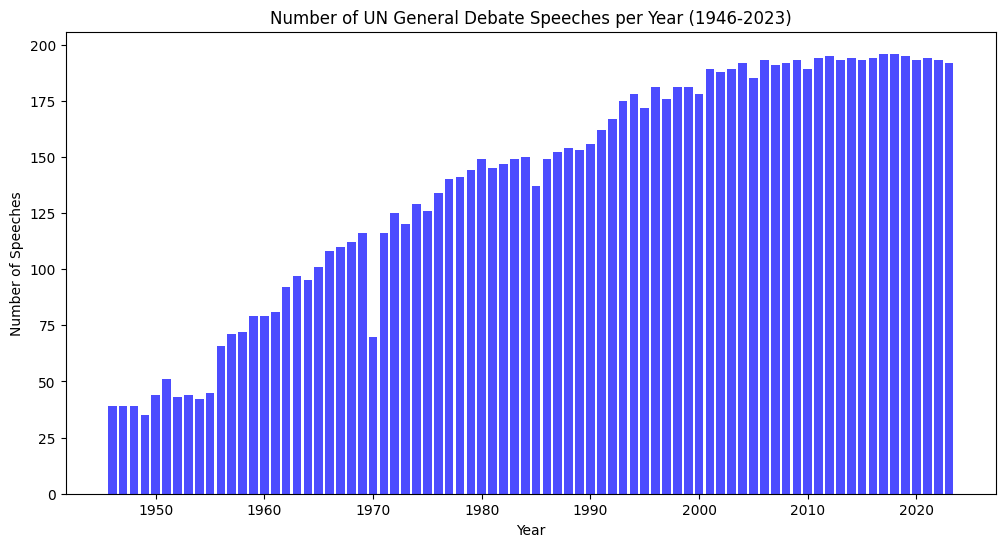

In [8]:
speeches_per_year = df["year"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(speeches_per_year.index, speeches_per_year.values, color="blue", alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Number of Speeches")
plt.title("Number of UN General Debate Speeches per Year (1946-2023)")
plt.show()

### Text Preprocessing

Load spaCy model:

In [9]:
try:
    sp = spacy.load("en_core_web_sm")
except OSError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

Initialize NLTK tools:

In [10]:
lmtzr = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

Preprocessing Function:

We build this function based on the preprocessing we did for the libraries. 

In [11]:
def preprocess_text(text, remove_stopwords=True, lemmatize=True, use_spacy=False):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if use_spacy:
        tokens = [token.text for token in sp(text)]  # Using preloaded spaCy model
    else:
        tokens = word_tokenize(text)  # Default: Use NLTK tokenization

    if remove_stopwords:
        custom_stopwords = {
            'per', 'also', 'percent', 'target', 'sdg', 'country', 'national',
            'government', 'development', 'year', 'system', 'sector', 
            'policy', 'support', 'access', 'public', 'new', 'level', 'sdgs', 'people'
        }
        stopwords_set = STOP_WORDS.union(custom_stopwords)
        tokens = [token for token in tokens if token not in stopwords_set]

    if lemmatize:
        tokens = [lmtzr.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

Apply preprocessing to the text column:

In [12]:
tqdm.pandas()
df["processed_text"] = df["text"].astype(str).progress_apply(
    lambda x: preprocess_text(x, remove_stopwords=True, lemmatize=True, use_spacy=False))

100%|██████████| 10760/10760 [01:36<00:00, 111.15it/s]


Look at the processed text:

In [13]:
sample_texts = df["processed_text"].sample(10, random_state=42)  
for i, text in enumerate(sample_texts, start=1):
    print(f"Processed Text {i}:\n{text}\n")

Processed Text 1:
uruguay belief united nation faith united nation organization continue contribute since became one founding member comforting note time crisis organization virtually participant debate expressed sentiment six decade ago united nation created promote regulate multilateral cooperation international community agreed address resolve common problem structure organization functioning organ right obligation member formulated san francisco charter reflected international political reality time course half century profound change structure international society actor multiplied become diverse dangerous manifestation violence threat peace foreseen drafter charter occur increasing frequency time intensification certain growing trend seriously affect wellbeing humanity degradation environment depletion natural resource epidemic contrast consumer society society live extreme poverty recent year particular general debate special emphasis placed need reform revitalize united nation 

### Further Data Exploration

We are using the pre-processed text data and start with looking at how the cumulative length of the speeches changed over time. Then, we do some simple topic modeling using LDA.

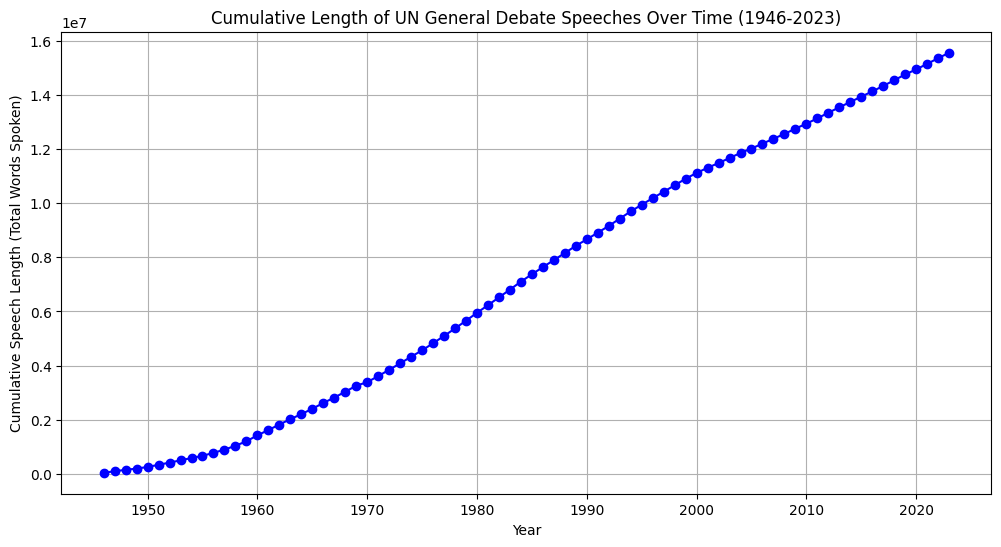

In [14]:
df["speech_length"] = df["processed_text"].apply(lambda x: len(x.split()))  # Count words in each speech
speech_length_per_year = df.groupby("year")["speech_length"].sum()
plt.figure(figsize=(12, 6))
plt.plot(speech_length_per_year.index, speech_length_per_year.cumsum(), marker="o", linestyle="-", color="blue")
plt.xlabel("Year")
plt.ylabel("Cumulative Speech Length (Total Words Spoken)")
plt.title("Cumulative Length of UN General Debate Speeches Over Time (1946-2023)")
plt.grid()
plt.show()

Tokenize the preprocessed text:

In [15]:
df["tokens"] = df["processed_text"].apply(lambda x: x.split())

Create a dictionary and corpus for LDA:

In [16]:
dictionary = corpora.Dictionary(df["tokens"])  # Create a mapping of words to unique IDs
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]  # Convert words to bag-of-words format

Corpus statistics:

In [17]:
print(f"Dictionary contains {len(dictionary)} unique words.")
print(f"Corpus contains {len(corpus)} documents.")

Dictionary contains 75498 unique words.
Corpus contains 10760 documents.


## LDA Model and Its Results

LDA is a probabilistic method for uncovering hidden thematic structures in large collections of text. In our workflow, we converted each speech into a bag‐of‐words format (`corpus`).

When we call `lda_model.print_topics(num_words=10)`, the model outputs the top words for each of the discovered topics along with the weights of those words. The weight of a word in a topic can be interpreted as its relative importance/contribution to that topic. A higher weight suggests that the word is more characteristic of that topic.

In the code output, each line shows a topic ID and a sequence of weighted word expressions. Topic 0, for instance, might emphasize words related to Africa. Another topic may reflect climate change discussions, including keywords such as “climate,” “change,” and “sustainable.” Topics often share high‐frequency words like “united” or “nation,” which is common in UN speeches.

To interpret each topic, it is helpful to read the most common words and then assign an intuitive label. For example, a topic 5 dominated by “climate,” “global,” and “sustainable” could be labeled as “Climate Change and Sustainability” which could be related to SDG 12 and SDG 13. By looking at the top words in each topic, one can tell that LDA has grouped semantically related terms into clusters.

This topic information can be used for further analysis. One might investigate how these topics change over time by examining the distribution of topics by year, or compare how different regions or countries focus on specific themes by looking at the topic mixtures in their speeches. This can provide insights into historical changes in discourse, policy priorities, and regional concerns within the UN General Debate context.

Train LDA Model:

In [18]:
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=10,  # Adjust number of topics as needed
    passes=10,  # Number of passes through the data
    random_state=42
)

The topics:

In [19]:
topics = lda_model.print_topics(num_words=10)

print("\n Top Topics in the UN Speeches:")
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")


 Top Topics in the UN Speeches:
Topic 0: 0.027*"africa" + 0.017*"african" + 0.015*"united" + 0.015*"south" + 0.013*"nation" + 0.009*"state" + 0.008*"delegation" + 0.008*"assembly" + 0.006*"organization" + 0.006*"republic"
Topic 1: 0.022*"nation" + 0.015*"united" + 0.012*"world" + 0.007*"u" + 0.006*"one" + 0.006*"must" + 0.005*"would" + 0.005*"problem" + 0.005*"country" + 0.005*"assembly"
Topic 2: 0.015*"nation" + 0.012*"united" + 0.009*"international" + 0.008*"state" + 0.007*"world" + 0.007*"would" + 0.006*"peace" + 0.006*"assembly" + 0.006*"problem" + 0.005*"country"
Topic 3: 0.020*"international" + 0.013*"security" + 0.011*"peace" + 0.011*"state" + 0.008*"region" + 0.008*"resolution" + 0.008*"united" + 0.007*"effort" + 0.006*"council" + 0.006*"nation"
Topic 4: 0.016*"people" + 0.012*"arab" + 0.011*"state" + 0.011*"israel" + 0.011*"world" + 0.011*"country" + 0.010*"united" + 0.009*"peace" + 0.008*"struggle" + 0.008*"aggression"
Topic 5: 0.011*"global" + 0.010*"climate" + 0.009*"natio

### *Apply SDG Dictionaries to UN Speeches*

Load the SDG dictionary:

In [20]:
with open("filtered_sdg_dictionaries.json", "r") as f:
    sdg_dict_json = json.load(f)

In [21]:
print(json.dumps(sdg_dict_json, indent=4))

{
    "df_sdg01": {
        "poverty": 0.5990341043716607,
        "social": 0.18805810115815846,
        "child": 0.16028320824891368,
        "service": 0.14980986600587126,
        "household": 0.1364614886372878,
        "income": 0.13522933072634163,
        "population": 0.12629618587198194,
        "family": 0.11469336554390555,
        "social protection": 0.11375233561152068,
        "programme": 0.10688969877457984,
        "living": 0.10216642678261953,
        "poor": 0.10031818991620028
    },
    "df_sdg02": {
        "food": 0.6652925779867462,
        "agricultural": 0.2521156880816349,
        "agriculture": 0.24433716412993295,
        "production": 0.1733009380415957,
        "nutrition": 0.162285929432853,
        "security": 0.15511291880158665,
        "sustainable": 0.1532826778717744,
        "child": 0.14584732409441223
    },
    "df_sdg03": {
        "health": 0.7354832640030018,
        "service": 0.18925098222615794,
        "disease": 0.16082334717028865,


##### Functions to count SDG mentions in a given text:

**(i) Using TF-IDF scores**

In [22]:
def count_sdg_mentions_tfidf(text, sdg_dict):
    sdg_scores = defaultdict(float)  # Use float to store weighted scores
    
    for sdg, terms in sdg_dict.items():
        for term, tfidf_score in terms.items():  # Extract term + TF-IDF score
            occurrences = text.count(term)  # Count occurrences of the term
            sdg_scores[sdg] += occurrences * tfidf_score  # Weight by TF-IDF

    return sdg_scores

**(ii) Normalizing by total words**

In [23]:
def count_sdg_mentions_tfidf_normalized(text, sdg_dict):
    sdg_scores = defaultdict(float)  # Use float for weighted scores
    
    words = text.split()  # Tokenize text
    total_words = len(words) if len(words) > 0 else 1  # Avoid division by zero

    for sdg, terms in sdg_dict.items():
        for term, tfidf_score in terms.items():
            occurrences = text.count(term)  # Count occurrences
            sdg_scores[sdg] += (occurrences * tfidf_score) / total_words  # Normalize by total words

    return sdg_scores

Apply SDG counting to each speech:

In [24]:
df["sdg_counts"] = df["processed_text"].apply(lambda x: count_sdg_mentions_tfidf(x, sdg_dict_json)) # change here to 'count_sdg_mentions_tfidf_normalized' evetually

sdg_columns = list(sdg_dict_json.keys()) 
for sdg in sdg_columns:
    df[sdg] = df["sdg_counts"].apply(lambda x: x.get(sdg, 0))  

Checking a few speeches and their SDG counts:

In [25]:
df[["year", "ccodealp", "processed_text"] + sdg_columns].sample(5, random_state=42)

year ccodealp                                     processed_text  \
10080  2003      URY  uruguay belief united nation faith united nati...   
8136   2021      PRY  mr president general assembly mr secretarygene...   
8409   2011      RWA  world continues deal crisis including conflict...   
8566   1981      SEN  thirtysixth session general assembly opened at...   
8818   2001      SLV  congratulate sir election preside general asse...   

       df_sdg01  df_sdg02  df_sdg03  df_sdg04  df_sdg05  df_sdg06  df_sdg07  \
10080  1.198068  1.142871  0.536867  0.000000  2.318011  0.207735  0.000000   
8136   0.980900  1.776363  1.144521  0.418642  1.416972  1.779536  1.874208   
8409   0.666341  0.153283  0.157479  0.000000  0.603340  0.236668  0.224130   
8566   0.787092  1.706242  1.865027  0.125396  8.513721  0.103868  0.560324   
8818   1.325494  3.146527  1.656800  0.125396  3.308673  0.103868  0.426882   

       df_sdg08  df_sdg09  df_sdg10  df_sdg11  df_sdg12  df_sdg13  df_sdg14  \
10080  1.930621  1.206383  1.584863  0.802672  0.829002  2.176948  2.942640   
8136   1.000830  1.370729  2.326023  1.469779  1.465285  3.141331  0.930236   
8409   1.286243  0.885059  2.072784  1.108170  0.855975  0.182092  1.048483   
8566   5.311600  3.947133  7.852006  2.762611  0.780451  1.035640  2.131601   
8818   5.755522  3.732633  5.823695  2.834351  2.437916  1.326005  2.003033   

       df_sdg15   df_sdg16   df_sdg17  
10080  1.737752   4.373540   6.509160  
8136   0.666377   2.622739   4.292033  
8409   1.072788   0.588436   1.863680  
8566   2.451666  12.666001  18.213213  
8818   2.484338   5.798768  11.415283

##### **SDG Count Distributions**

We can see that this more or less just shows length of dictionaries and weights - note, that the dictionaries are not ment for comparison of topics.

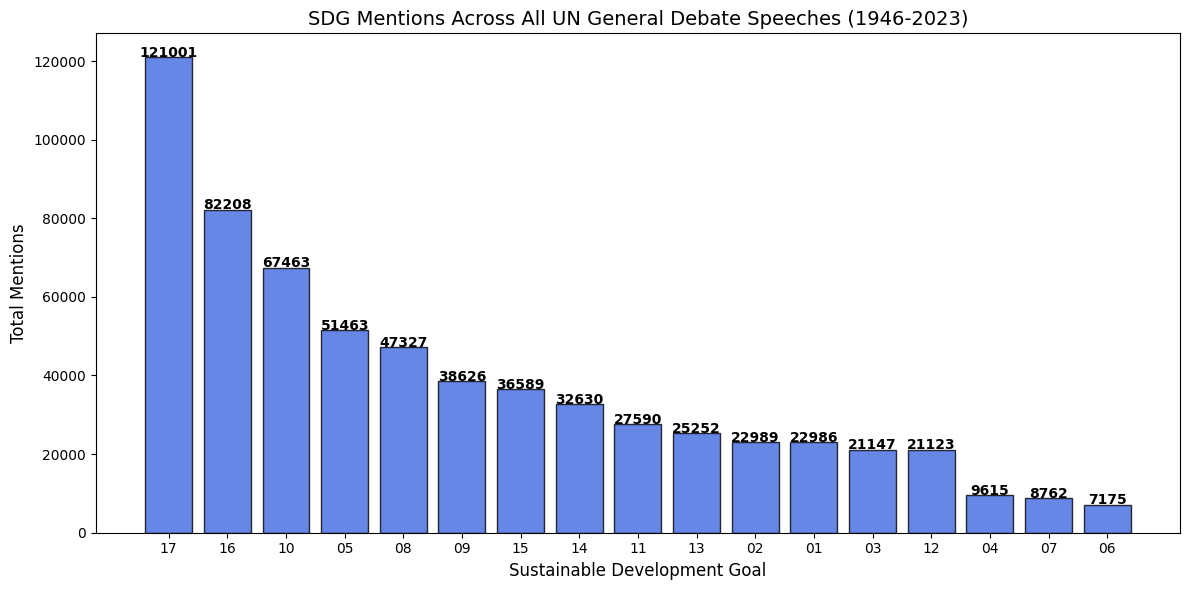

In [26]:
sdg_totals = df[sdg_columns].sum().sort_values(ascending=False)
sdg_labels = [sdg.replace("df_sdg", "") for sdg in sdg_totals.index] 
plt.figure(figsize=(12, 6))
bars = plt.bar(sdg_labels, sdg_totals, color="royalblue", alpha=0.8, edgecolor="black")
plt.xlabel("Sustainable Development Goal", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("SDG Mentions Across All UN General Debate Speeches (1946-2023)", fontsize=14)
plt.xticks(rotation=0, fontsize=10)
for bar, label in zip(bars, sdg_totals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, str(int(label)), 
             ha="center", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
import plotly.express as px

def create_sdg_stacked_area(df, sdg_columns):
    # Create year-wise proportions
    sdg_by_year = df.groupby("year")[sdg_columns].sum()
    sdg_proportions = sdg_by_year.div(sdg_by_year.sum(axis=1), axis=0) * 100
    sdg_proportions = sdg_proportions.reset_index()
    
    # Melt the dataframe
    sdg_melted = pd.melt(sdg_proportions, 
                        id_vars=['year'], 
                        value_vars=sdg_columns,
                        var_name='SDG', 
                        value_name='Percentage')
    
    # Clean SDG names
    sdg_melted['SDG'] = sdg_melted['SDG'].str.replace('df_sdg', '')
    
    # Create stacked area chart
    fig = px.area(sdg_melted,
                  x='year',
                  y='Percentage',
                  color='SDG',
                  title='SDG Mentions Distribution in UN Speeches (1946-2023)')
    
    fig.update_layout(
        xaxis_title="Year",
        yaxis_title="Percentage",
        legend_title="SDGs"
    )
    
    return fig

# show visual
fig = create_sdg_stacked_area(df, sdg_columns)
fig.show()

On this stacked area chart we see how mentions of each Sustainable Development Goal (SDG) contribute to the total SDG‐related references in UN speeches over time. Each colored band represents one SDG, and the width of that band (from bottom to top) indicates the percentage share of references for that SDG in a given year.

For example, we see a smooth line for SDG 1 (bottom one), but there is a visible fluctutation throughout the whole period for SDG 12, depending on years it might spike or plummet rapidly; 

Around 2007–2009, there is a subtle but noticeable shift in the balance of SDG references on the chart, which likely reflects the global economic turbulence of that period. Almost all SDGs are affected except SDG 1 and SDGs 16-17; 

Years 2019–2021 also show a uptick in references to health aassociated with SDG 3, but mostly all SDGs were affected as well. This change is consistent with the COVID‑19 pandemic taking center stage, triggering heightened attention to public health, social protection, and broader systemic vulnerabilities. 

The overall composition remains fairly steady, but those two periods—2007–2009 and 2019–2021—stand out as points where external global events reshaped the relative emphasis on different SDGs in UN speeches.

#### **Comparing SDG Mentions by Metadata**

##### *(a) SDG Mentions by Year*

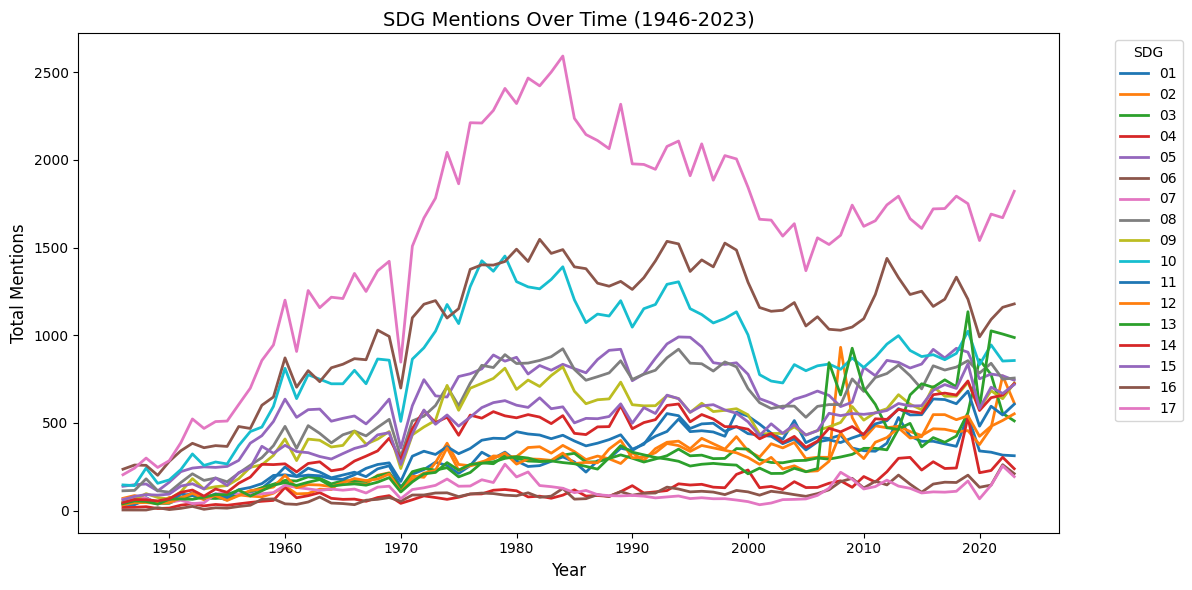

In [28]:
sdg_by_year = df.groupby("year")[sdg_columns].sum()
sdg_labels = [sdg.replace("df_sdg", "") for sdg in sdg_columns] 
plt.figure(figsize=(12, 6))
for sdg, label in zip(sdg_columns, sdg_labels):
    plt.plot(sdg_by_year.index, sdg_by_year[sdg], label=label, linewidth=2)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("SDG Mentions Over Time (1946-2023)", fontsize=14)
plt.legend(title="SDG", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

##### *(a) SDG Mentions by Country*

(Note, that this is more to tell us what countries may be interesting to take a closer look.)

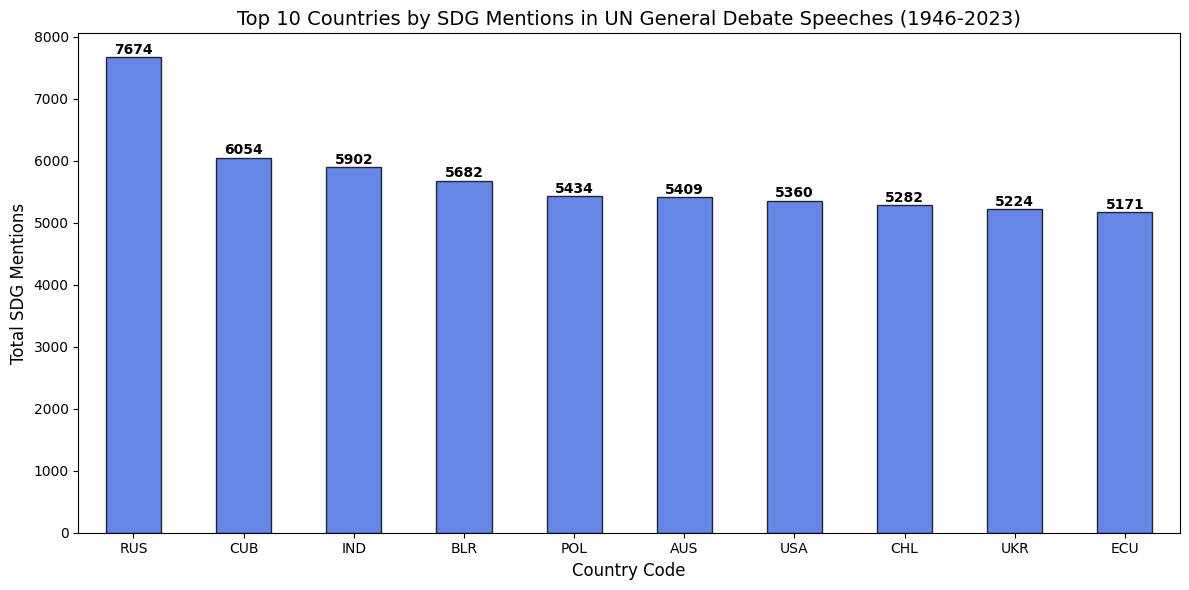

In [29]:
sdg_by_country = df.groupby("ccodealp")[sdg_columns].sum()
total_mentions_by_country = sdg_by_country.sum(axis=1)
top_countries = total_mentions_by_country.sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_countries.plot(kind="bar", color="royalblue", alpha=0.8, edgecolor="black")
plt.xlabel("Country Code", fontsize=12)
plt.ylabel("Total SDG Mentions", fontsize=12)
plt.title("Top 10 Countries by SDG Mentions in UN General Debate Speeches (1946-2023)", fontsize=14)
plt.xticks(rotation=0, fontsize=10)
for index, value in enumerate(top_countries):
    plt.text(index, value + 50, str(int(value)), ha="center", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()

/var/folders/j1/cd2zy8mn1490bvy7qqr2v9sh0000gn/T/ipykernel_62642/2054272044.py:35: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/j1/cd2zy8mn1490bvy7qqr2v9sh0000gn/T/ipykernel_62642/2054272044.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



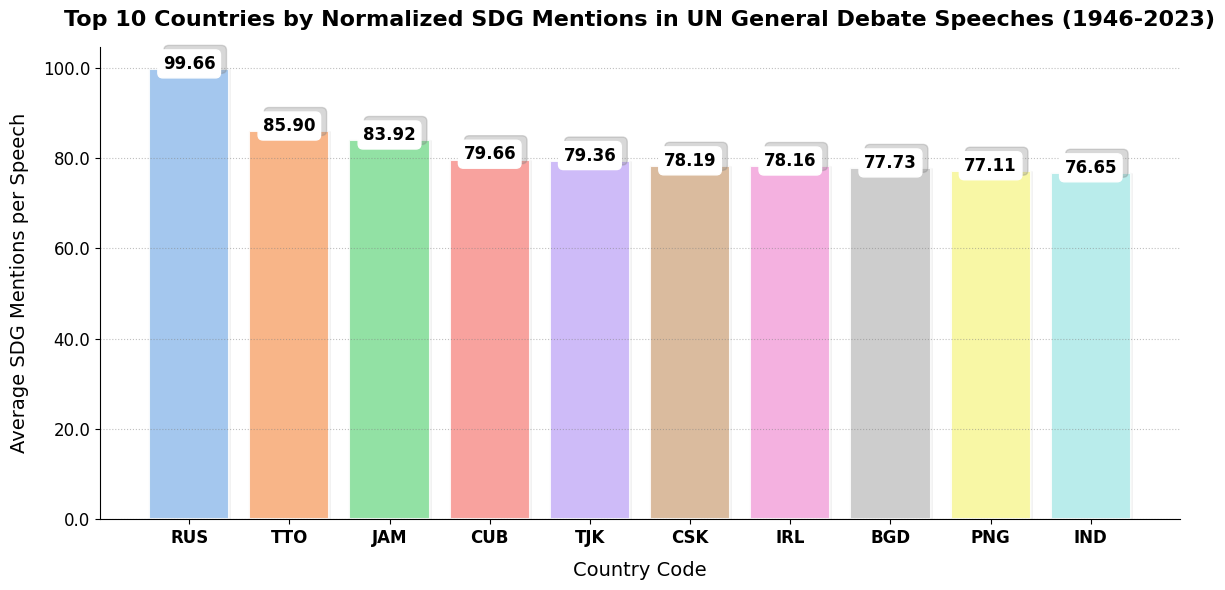

In [31]:
import seaborn as sns
entries_per_country = df["ccodealp"].value_counts()

sdg_by_country = df.groupby("ccodealp")[sdg_columns].sum()
total_mentions_by_country = sdg_by_country.sum(axis=1)

# Normalize by the number of speeches per country
normalized_mentions = total_mentions_by_country / entries_per_country

top_countries = normalized_mentions.sort_values(ascending=False).head(10)


# Create the figure with a white background
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

# Set the background color of the axes to white as well
ax.set_facecolor("white")
colors = sns.color_palette("pastel")

bars = ax.bar(top_countries.index, top_countries.values, color=colors, edgecolor="white", linewidth=1.5, alpha=0.9)

# Add a soft shadow effect to create depth
for bar in bars:
    ax.add_patch(plt.Rectangle(
        (bar.get_x(), 0), bar.get_width(), bar.get_height(),
        color="gray", alpha=0.5, zorder=0))

# Labels and Title
ax.set_xlabel("Country Code", fontsize=14, labelpad=10, color="black")
ax.set_ylabel("Average SDG Mentions per Speech", fontsize=14, labelpad=10, color="black")
ax.set_title("Top 10 Countries by Normalized SDG Mentions in UN General Debate Speeches (1946-2023)", 
             fontsize=16, fontweight="bold", pad=15, color="black")

# Customize ticks
ax.set_xticklabels(top_countries.index, fontsize=12, fontweight="bold", color="black")
ax.set_yticklabels(ax.get_yticks(), fontsize=12, color="black")

# Add gridlines with a clean, modern look
ax.grid(axis="y", linestyle="dotted", alpha=0.5, color="gray")

# Add text annotations with drop shadow inside rounded white boxes
for bar in bars:
    height = bar.get_height()
    # Main annotation text
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{height:.2f}", 
             ha="center", fontsize=12, fontweight="bold", color="black",
             bbox=dict(facecolor="white", edgecolor="white", boxstyle="round,pad=0.3"),
             zorder=2)
    
    # Drop shadow (slightly offset behind the main text)
    ax.text(bar.get_x() + bar.get_width()/2 + 0.06, height + 0.1 + 1, f"{height:.2f}", 
             ha="center", fontsize=12, fontweight="bold", color="gray", alpha=0.3,
             bbox=dict(facecolor="gray", edgecolor="gray", boxstyle="round,pad=0.3", alpha=0.3),
             zorder=1)


# Remove unnecessary spines for a clean look
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Tight layout to remove extra space
plt.tight_layout()

# Show the plot
plt.show()


**Generate SDG Trends for different Countries**

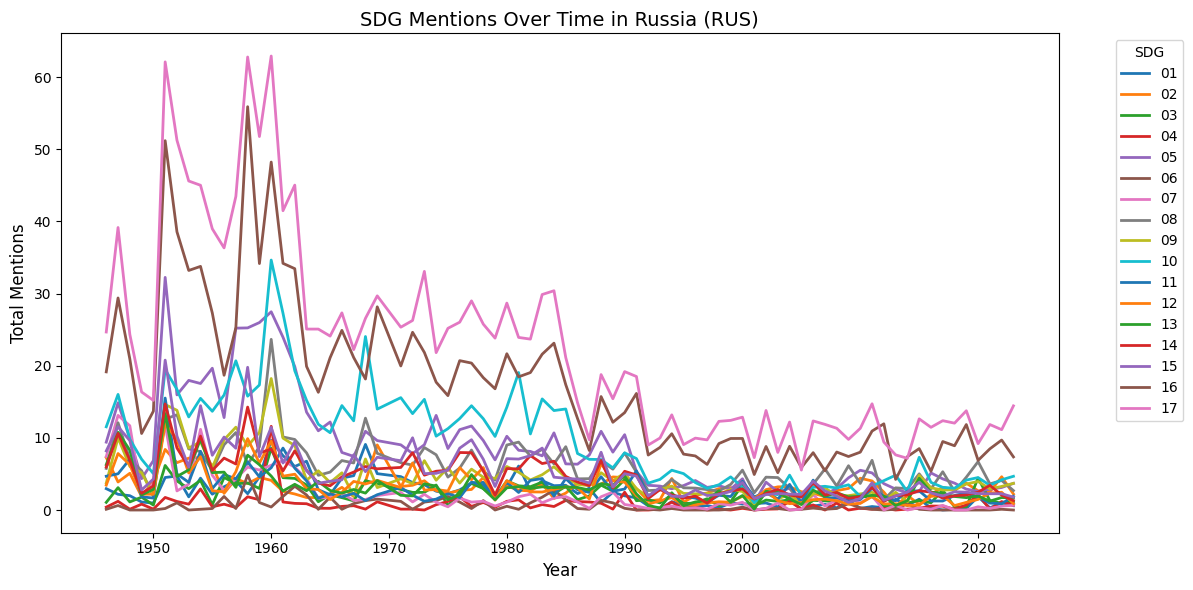

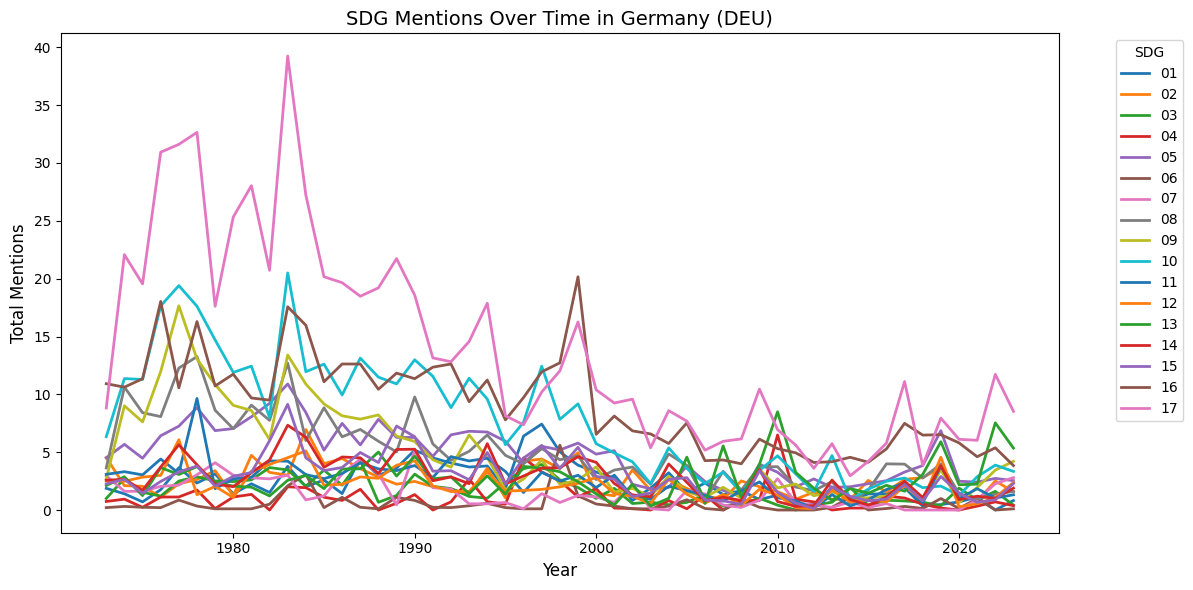

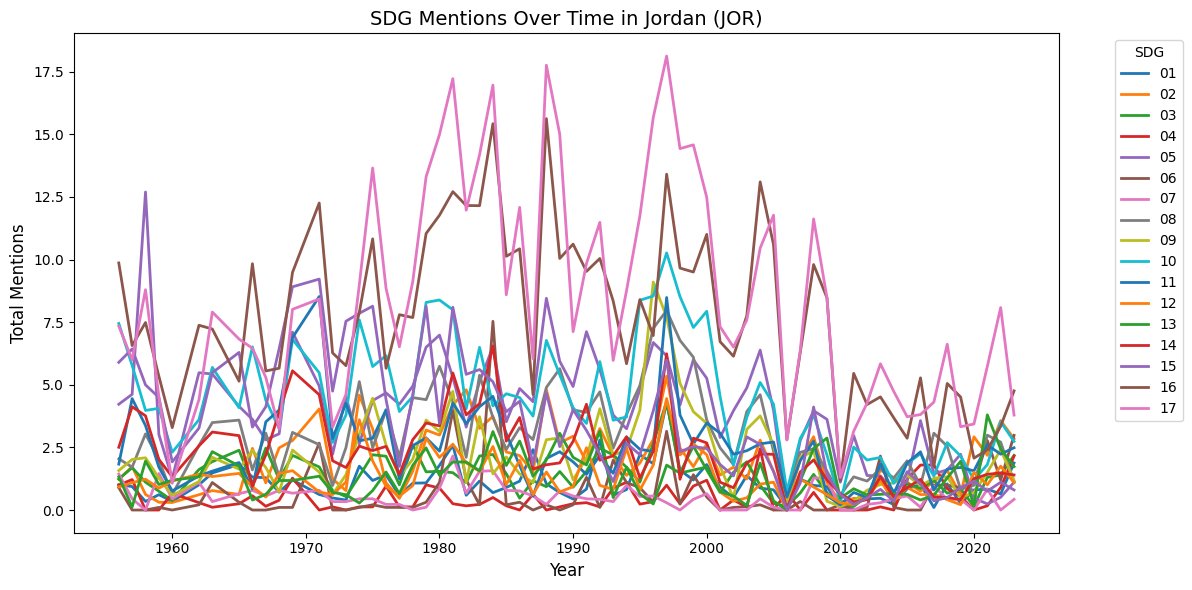

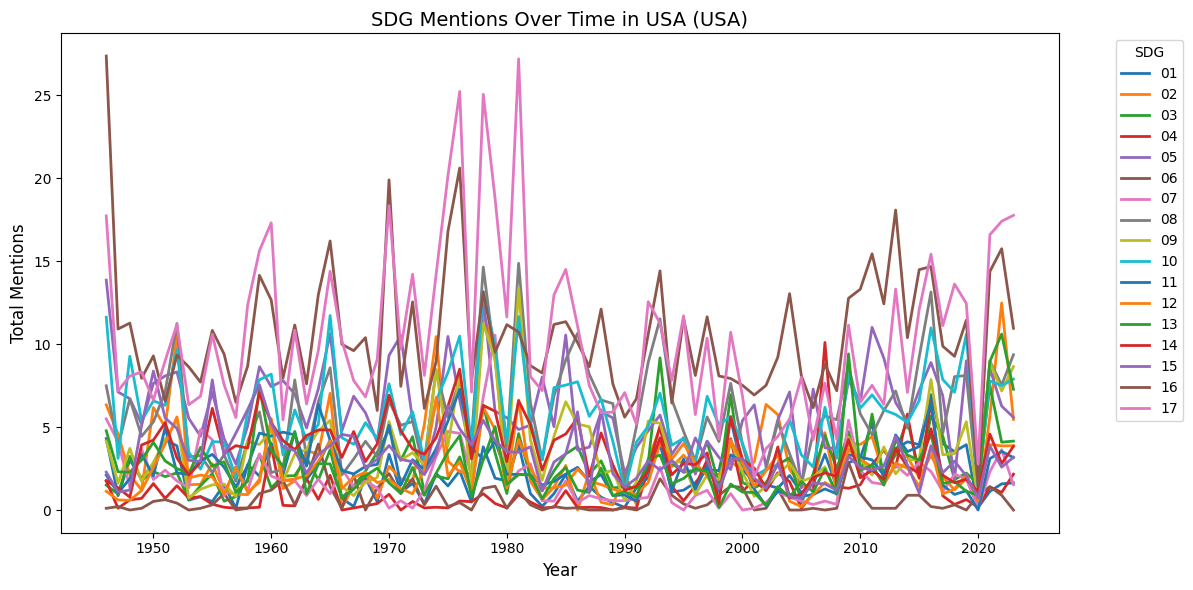

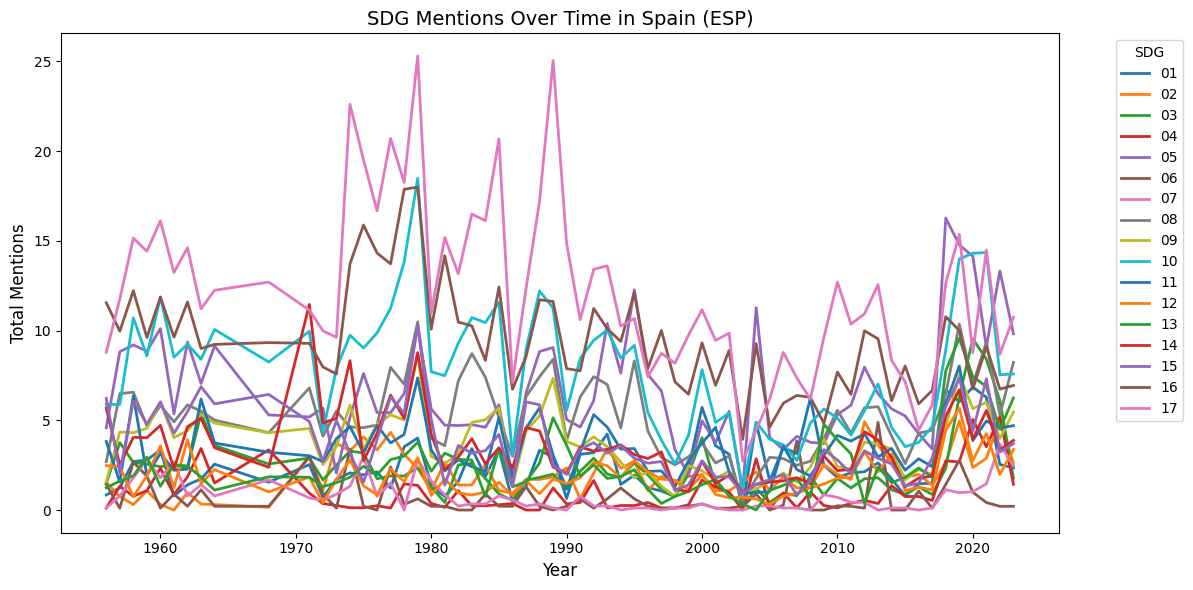

In [32]:
countries_of_interest = {
    "Russia": "RUS",
    "Germany": "DEU",
    "Jordan": "JOR",
    "USA": "USA",
    "Spain": "ESP"
}

for country, country_code in countries_of_interest.items():
    sdg_by_year_country = df[df["ccodealp"] == country_code].groupby("year")[sdg_columns].sum()

    if sdg_by_year_country.empty:
        print(f"No data available for {country} ({country_code})")
        continue

    sdg_labels = [sdg.replace("df_sdg", "") for sdg in sdg_columns]

    plt.figure(figsize=(12, 6))
    for sdg, label in zip(sdg_columns, sdg_labels):
        plt.plot(sdg_by_year_country.index, sdg_by_year_country[sdg], label=label, linewidth=2)

    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Total Mentions", fontsize=12)
    plt.title(f"SDG Mentions Over Time in {country} ({country_code})", fontsize=14)
    plt.legend(title="SDG", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()

In [33]:
# SDG Names for visuals

def get_sdg_names():
    """Create a dictionary mapping SDG numbers to their full names"""
    return {
        'SDG 01': 'SDG 1: No Poverty',
        'SDG 02': 'SDG 2: Zero Hunger',
        'SDG 03': 'SDG 3: Good Health and Well-being',
        'SDG 04': 'SDG 4: Quality Education',
        'SDG 05': 'SDG 5: Gender Equality',
        'SDG 06': 'SDG 6: Clean Water and Sanitation',
        'SDG 07': 'SDG 7: Affordable and Clean Energy',
        'SDG 08': 'SDG 8: Decent Work and Economic Growth',
        'SDG 09': 'SDG 9: Industry, Innovation and Infrastructure',
        'SDG 10': 'SDG 10: Reduced Inequalities',
        'SDG 11': 'SDG 11: Sustainable Cities and Communities',
        'SDG 12': 'SDG 12: Responsible Consumption and Production',
        'SDG 13': 'SDG 13: Climate Action',
        'SDG 14': 'SDG 14: Life Below Water',
        'SDG 15': 'SDG 15: Life on Land',
        'SDG 16': 'SDG 16: Peace, Justice and Strong Institutions',
        'SDG 17': 'SDG 17: Partnerships for the Goals'
    }

In [34]:
import pandas as pd
import plotly.graph_objects as go
    
def create_country_region_mapping():
    """Create a dictionary mapping country codes to regions"""
    return {
        # Europe
        'ALB': 'Europe', 'AND': 'Europe', 'AUT': 'Europe', 'BEL': 'Europe', 'BGR': 'Europe', 
        'BIH': 'Europe', 'BLR': 'Europe', 'CHE': 'Europe', 'CYP': 'Europe', 'CZE': 'Europe', 
        'DEU': 'Europe', 'DNK': 'Europe', 'ESP': 'Europe', 'EST': 'Europe', 'FIN': 'Europe', 
        'FRA': 'Europe', 'GBR': 'Europe', 'GRC': 'Europe', 'HRV': 'Europe', 'HUN': 'Europe', 
        'IRL': 'Europe', 'ISL': 'Europe', 'ITA': 'Europe', 'LTU': 'Europe', 'LUX': 'Europe', 
        'LVA': 'Europe', 'MDA': 'Europe', 'MKD': 'Europe', 'MLT': 'Europe', 'MNE': 'Europe', 
        'NLD': 'Europe', 'NOR': 'Europe', 'POL': 'Europe', 'PRT': 'Europe', 'ROU': 'Europe', 
        'RUS': 'Europe', 'SRB': 'Europe', 'SVK': 'Europe', 'SVN': 'Europe', 'SWE': 'Europe', 
        'UKR': 'Europe',
        
        # Asia
        'AFG': 'Asia', 'ARE': 'Asia', 'ARM': 'Asia', 'AZE': 'Asia', 'BGD': 'Asia', 
        'BHR': 'Asia', 'BRN': 'Asia', 'BTN': 'Asia', 'CHN': 'Asia', 'GEO': 'Asia', 
        'IDN': 'Asia', 'IND': 'Asia', 'IRN': 'Asia', 'IRQ': 'Asia', 'ISR': 'Asia', 
        'JOR': 'Asia', 'JPN': 'Asia', 'KAZ': 'Asia', 'KGZ': 'Asia', 'KHM': 'Asia', 
        'KOR': 'Asia', 'KWT': 'Asia', 'LAO': 'Asia', 'LBN': 'Asia', 'LKA': 'Asia', 
        'MMR': 'Asia', 'MNG': 'Asia', 'MYS': 'Asia', 'NPL': 'Asia', 'OMN': 'Asia', 
        'PAK': 'Asia', 'PHL': 'Asia', 'PRK': 'Asia', 'QAT': 'Asia', 'SAU': 'Asia', 
        'SGP': 'Asia', 'SYR': 'Asia', 'THA': 'Asia', 'TJK': 'Asia', 'TKM': 'Asia', 
        'TLS': 'Asia', 'TUR': 'Asia', 'UZB': 'Asia', 'VNM': 'Asia', 'YEM': 'Asia',
        
        # Africa
        'AGO': 'Africa', 'BDI': 'Africa', 'BEN': 'Africa', 'BFA': 'Africa', 'BWA': 'Africa', 
        'CAF': 'Africa', 'CIV': 'Africa', 'CMR': 'Africa', 'COD': 'Africa', 'COG': 'Africa', 
        'COM': 'Africa', 'CPV': 'Africa', 'DJI': 'Africa', 'DZA': 'Africa', 'EGY': 'Africa', 
        'ERI': 'Africa', 'ETH': 'Africa', 'GAB': 'Africa', 'GHA': 'Africa', 'GIN': 'Africa', 
        'GMB': 'Africa', 'GNB': 'Africa', 'GNQ': 'Africa', 'KEN': 'Africa', 'LBR': 'Africa', 
        'LBY': 'Africa', 'LSO': 'Africa', 'MAR': 'Africa', 'MDG': 'Africa', 'MLI': 'Africa', 
        'MOZ': 'Africa', 'MRT': 'Africa', 'MUS': 'Africa', 'MWI': 'Africa', 'NAM': 'Africa', 
        'NER': 'Africa', 'NGA': 'Africa', 'RWA': 'Africa', 'SDN': 'Africa', 'SEN': 'Africa', 
        'SLE': 'Africa', 'SOM': 'Africa', 'SSD': 'Africa', 'SWZ': 'Africa', 'SYC': 'Africa', 
        'TCD': 'Africa', 'TGO': 'Africa', 'TUN': 'Africa', 'TZA': 'Africa', 'UGA': 'Africa', 
        'ZAF': 'Africa', 'ZMB': 'Africa', 'ZWE': 'Africa',
        
        # Americas
        'ARG': 'Americas', 'BHS': 'Americas', 'BLZ': 'Americas', 'BOL': 'Americas', 'BRA': 'Americas', 
        'BRB': 'Americas', 'CAN': 'Americas', 'CHL': 'Americas', 'COL': 'Americas', 'CRI': 'Americas', 
        'CUB': 'Americas', 'DMA': 'Americas', 'DOM': 'Americas', 'ECU': 'Americas', 'GRD': 'Americas', 
        'GTM': 'Americas', 'GUY': 'Americas', 'HND': 'Americas', 'HTI': 'Americas', 'JAM': 'Americas', 
        'KNA': 'Americas', 'LCA': 'Americas', 'MEX': 'Americas', 'NIC': 'Americas', 'PAN': 'Americas', 
        'PER': 'Americas', 'PRY': 'Americas', 'SLV': 'Americas', 'SUR': 'Americas', 'TTO': 'Americas', 
        'URY': 'Americas', 'USA': 'Americas', 'VCT': 'Americas', 'VEN': 'Americas',
        
        # Oceania
        'AUS': 'Oceania', 'FJI': 'Oceania', 'FSM': 'Oceania', 'KIR': 'Oceania', 'MHL': 'Oceania',
        'NRU': 'Oceania', 'NZL': 'Oceania', 'PLW': 'Oceania', 'PNG': 'Oceania', 'SLB': 'Oceania',
        'TON': 'Oceania', 'TUV': 'Oceania', 'VUT': 'Oceania', 'WSM': 'Oceania'
    }


def create_sankey_diagram(df, sdg_columns, year_range=None):
    # Get SDG names mapping
    sdg_names = get_sdg_names()
    
    # Add region information and handle NaN values
    country_to_region = create_country_region_mapping()
    df['region'] = df['ccodealp'].map(country_to_region)
    
    # Remove rows with NaN regions
    df = df[df['region'].notna()]
    
    # Filter by year range if specified
    if year_range:
        df = df[df['year'].between(year_range[0], year_range[1])]
    
    # Aggregate data by region and SDG
    region_sdg_flows = []
    for region in sorted(df['region'].unique().tolist()):
        region_data = df[df['region'] == region]
        for sdg in sdg_columns:
            sdg_number = 'SDG ' + sdg.replace('df_sdg', '')
            sdg_full_name = sdg_names.get(sdg_number, sdg_number)
            
            total_mentions = region_data[sdg].sum()
            if total_mentions > 0:
                region_sdg_flows.append({
                    'region': region,
                    'sdg': sdg_full_name,
                    'value': total_mentions
                })
    
    # Convert to DataFrame for easier manipulation
    flows_df = pd.DataFrame(region_sdg_flows)
    
    # Create node lists and get indices
    regions = sorted(flows_df['region'].unique().tolist())
    sdgs = flows_df['sdg'].unique().tolist()
    
    # Create custom hover text
    customdata = []
    for sdg in sdgs:
        sdg_data = flows_df[flows_df['sdg'] == sdg]
        text = f"<b>{sdg}</b><br>"
        for region in regions:
            if not sdg_data[sdg_data['region'] == region].empty:
                value = int(sdg_data[sdg_data['region'] == region]['value'].iloc[0])
                text += f"{region}: {value:,}<br>"
        text += f"<b>Total: {int(sdg_data['value'].sum()):,}</b>"
        customdata.append(text)
    
    # Combine regions and SDGs hover text
    region_hover = [f"<b>{region}</b><br>Total: {int(flows_df[flows_df['region'] == region]['value'].sum()):,}" 
                   for region in regions]
    node_customdata = region_hover + customdata
    
    # Create node lists and get indices
    nodes = list(regions) + list(sdgs)
    node_indices = {node: idx for idx, node in enumerate(nodes)}
    
    # Create source, target, and value lists
    sources = [node_indices[row['region']] for _, row in flows_df.iterrows()]
    targets = [node_indices[row['sdg']] for _, row in flows_df.iterrows()]
    values = flows_df['value'].tolist()
    
    # Create node colors
    region_colors = {
        'Europe': '#1f77b4',
        'Asia': '#ff7f0e',
        'Africa': '#2ca02c',
        'Americas': '#d62728',
        'Oceania': '#9467bd'
    }
    
    sdg_color = '#8c564b'
    node_colors = [region_colors.get(node, sdg_color) for node in nodes]
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes,
            color=node_colors,
            customdata=node_customdata,
            hoverlabel=dict(align='left'),
            hovertemplate='%{customdata}<extra></extra>'
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            hoverlabel=dict(align='left'),
            hovertemplate='Mentions: %{value:,.0f}<extra></extra>'
        )
    )])
    
    # Update layout
    title_text = 'Regional Contribution to SDG Discussions'
    if year_range:
        title_text += f' ({year_range[0]}-{year_range[1]})'
        
    fig.update_layout(
        title=dict(
            text=title_text,
            x=0.5,
            y=0.95
        ),
        font_size=12,
        height=800,
        width=1200
    )
    
    return fig

# Usage
fig = create_sankey_diagram(df, sdg_columns)
fig.show()

This is a Sankey diagram that visualizes how frequently each region’s speeches reference each of the 17 Sustainable Development Goals.

Each flow or “stream” represents the extent to which a given region’s remarks align with a particular SDG. **Thicker lines generally mean stronger emphasis on that goal**. By tracing lines from left to right, we can see which goals get the most attention from each region and compare patterns of SDG priorities across different parts of the world.

#### SDG Topic Correlation Matrix

In [35]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

def create_sdg_correlation_heatmap(df, sdg_columns, year_range=None):
    
    sdg_names = get_sdg_names()
    # Filter by year range if specified
    data = df.copy()
    if year_range:
        data = data[data['year'].between(year_range[0], year_range[1])]
    
    # Calculate correlation matrix
    corr_matrix = data[sdg_columns].corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix), k=1)
    corr_matrix_values = corr_matrix.values  # Convert to numpy array
    corr_matrix_values[mask == 1] = np.nan  # Set upper triangle to NaN
    
    
    # Clean SDG labels with proper zero-padding
    sdg_labels = []
    for col in sdg_columns:
        num = col.replace('df_sdg', '')
        # Zero-pad single digit numbers
        sdg_label = f"SDG {int(num):02d}"
        sdg_labels.append(sdg_label)
    
    # Create hover text matrix
    hover_text = np.empty_like(corr_matrix_values, dtype=object)
    for i in range(len(sdg_labels)):
        for j in range(len(sdg_labels)):
            if i >= j:  # Only for lower triangle
                sdg1 = sdg_labels[i]
                sdg2 = sdg_labels[j]
                hover_text[i,j] = (
                    f"{sdg1}: {sdg_names[sdg1]}<br>"
                    f"{sdg2}: {sdg_names[sdg2]}<br>"
                    f"Correlation: {corr_matrix_values[i,j]:.2f}"
                )
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix_values,
        x=sdg_labels,
        y=sdg_labels,
        colorscale='RdBu',
        zmid=0,
        text=np.round(corr_matrix_values, 2),
        texttemplate='%{text}',
        textfont={"size": 10},
        hovertext=hover_text,
        hoverinfo='text',
        hoverongaps=False
    ))
    
    # Update layout
    title_text = 'SDG Topic Correlation Matrix'
    if year_range:
        title_text += f' ({year_range[0]}-{year_range[1]})'
        
    fig.update_layout(
        title=dict(
            text=title_text,
            x=0.5,
            y=0.95
        ),
        width=900,
        height=800,
        xaxis_title="",
        yaxis_title="",
        xaxis={'side': 'bottom'},
        yaxis={'side': 'left'},
        plot_bgcolor='white'
    )
    
    return fig

# Usage
fig = create_sdg_correlation_heatmap(df, sdg_columns)
fig.show()

This visual shows correlations between SDGs (which goals tend to be mentioned together)

It seems that SDG 09 and SDG 17 are most correlated with 0.82 as well as SDG 17 and SDG 10;
We see the high correlation **between SDG 9** (Industry, Innovation, and Infrastructure) **and SDG 17** (Partnerships for the Goals) because infrastructure development often hinges on international collaboration, technology transfer, and capacity-building partnerships. Speeches referencing new infrastructure projects or innovations frequently also cite the need for external funding, shared research, or cross-border alliances, which fall under SDG 17. 

## **Focussed Analysis**

### *1) To what extent do UN General Assembly speeches reflect shifts in SDG-related discourse over time, and can we identify trends corresponding to major global agreements or initiatives?*

Defining SDGs and their key periods of interest:

In [36]:
sdg_focus = {
    "1": {"sdg": "df_sdg01", "title": "SDG 1 – No Poverty", "events": {2000: "MDGs", 2015: "SDGs"}},
    "3": {"sdg": "df_sdg03", "title": "SDG 3 – Good Health & Well-being", "events": {2000: "HIV/AIDS", 2020: "COVID-19"}},
    "5": {"sdg": "df_sdg05", "title": "SDG 5 – Gender Equality", "events": {1975: "1st Women's Conf", 2017: "#MeToo"}},
    "7": {"sdg": "df_sdg07", "title": "SDG 7 – Affordable & Clean Energy", "events": {1997: "Kyoto Protocol", 2015: "Paris Agreement"}},
    "13": {"sdg": "df_sdg13", "title": "SDG 13 – Climate Action", "events": {1992: "Rio Summit", 2015: "Paris Agreement"}}
}

Aggregate SDG mentions per year:

In [37]:
sdg_by_year = df.groupby("year")[sdg_columns].sum()

Generate plots for each selected SDG:

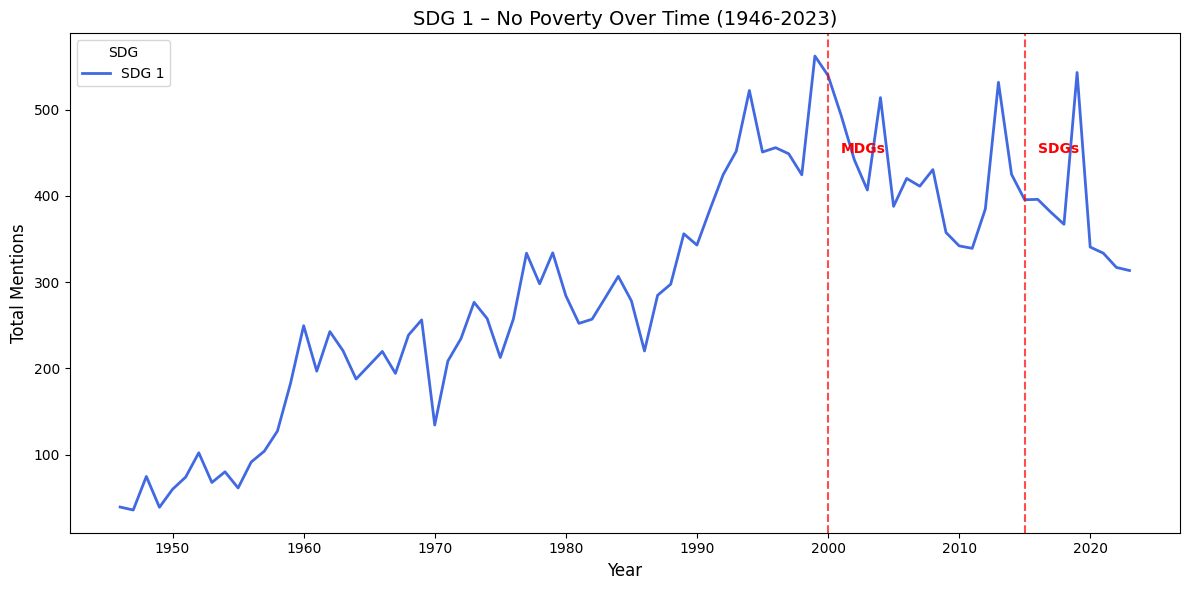

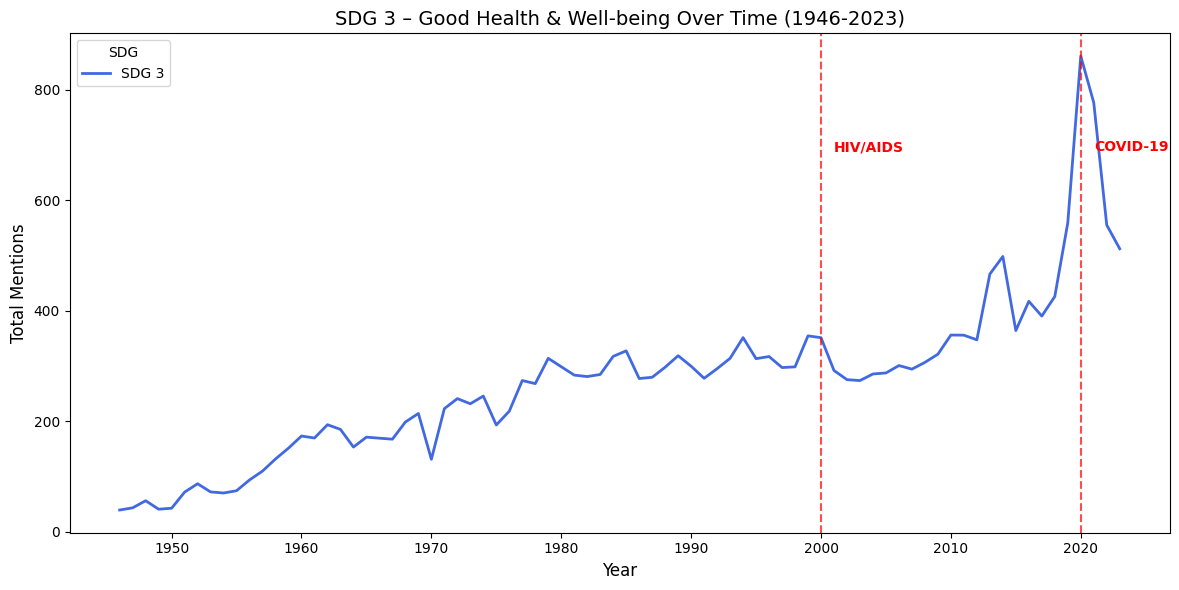

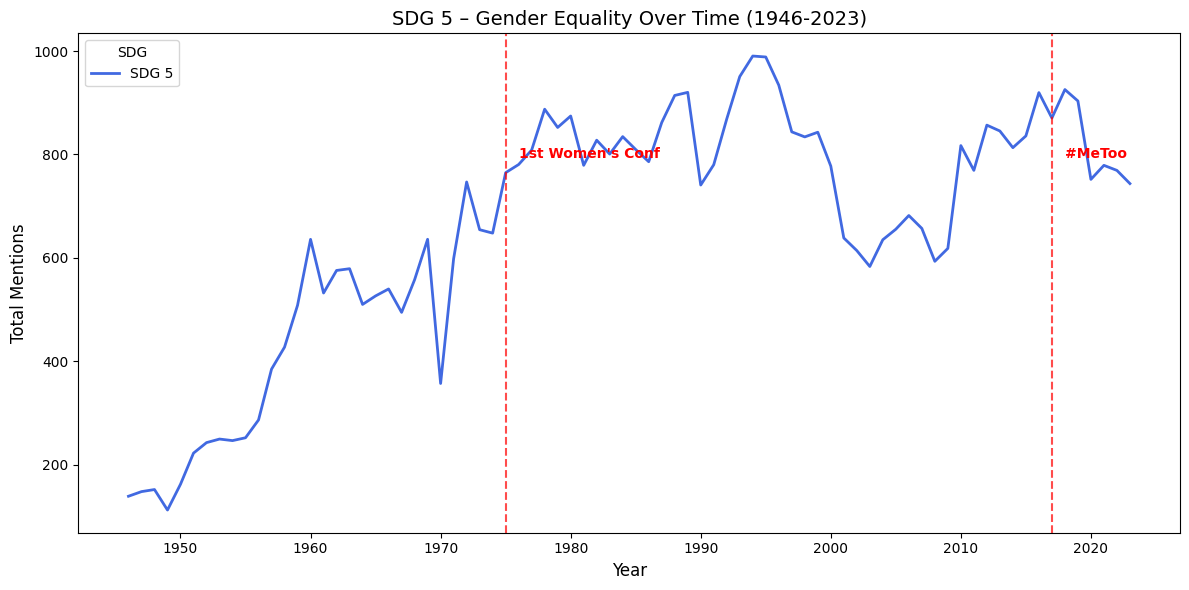

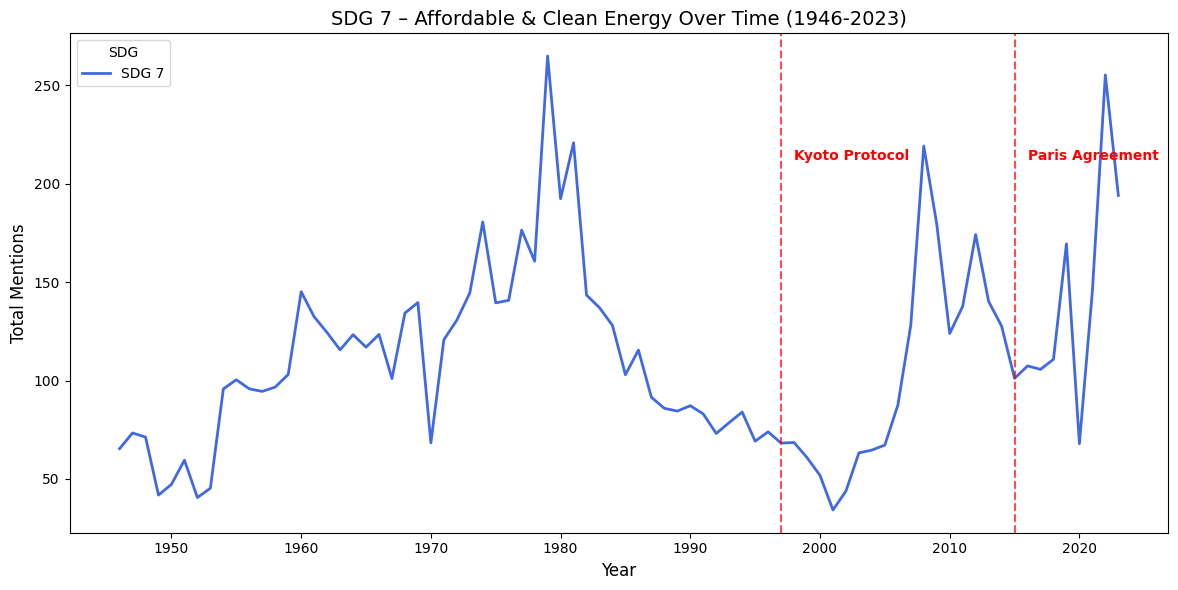

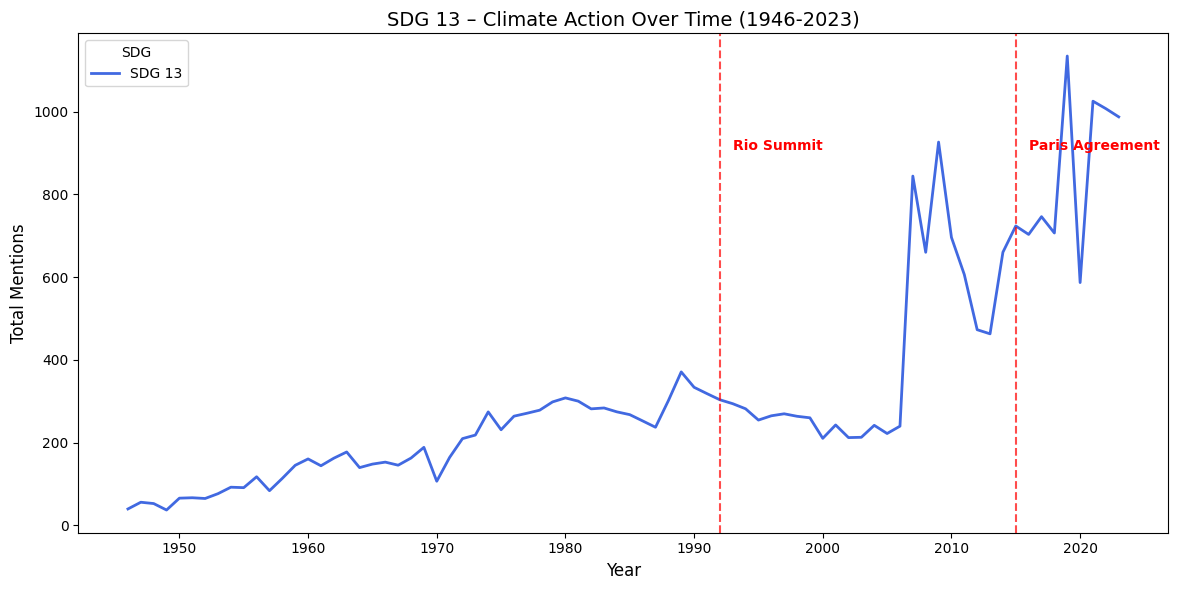

In [38]:
for sdg_num, sdg_info in sdg_focus.items():
    sdg_col = sdg_info["sdg"]
    
    if sdg_col not in sdg_by_year.columns:
        print(f"⚠ {sdg_info['title']} is missing in the dataset!")
        continue

    plt.figure(figsize=(12, 6))
    plt.plot(sdg_by_year.index, sdg_by_year[sdg_col], label=f"SDG {sdg_num}", color="royalblue", linewidth=2)

    for year, event in sdg_info["events"].items():
        plt.axvline(x=year, color="red", linestyle="--", alpha=0.7)
        plt.text(year + 1, sdg_by_year[sdg_col].max() * 0.8, event, color="red", fontsize=10, rotation=0, fontweight="bold")

    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Total Mentions", fontsize=12)
    plt.title(f"{sdg_info['title']} Over Time (1946-2023)", fontsize=14)
    plt.legend(title="SDG", loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()

#### *SDG 13 (Climate Action)*

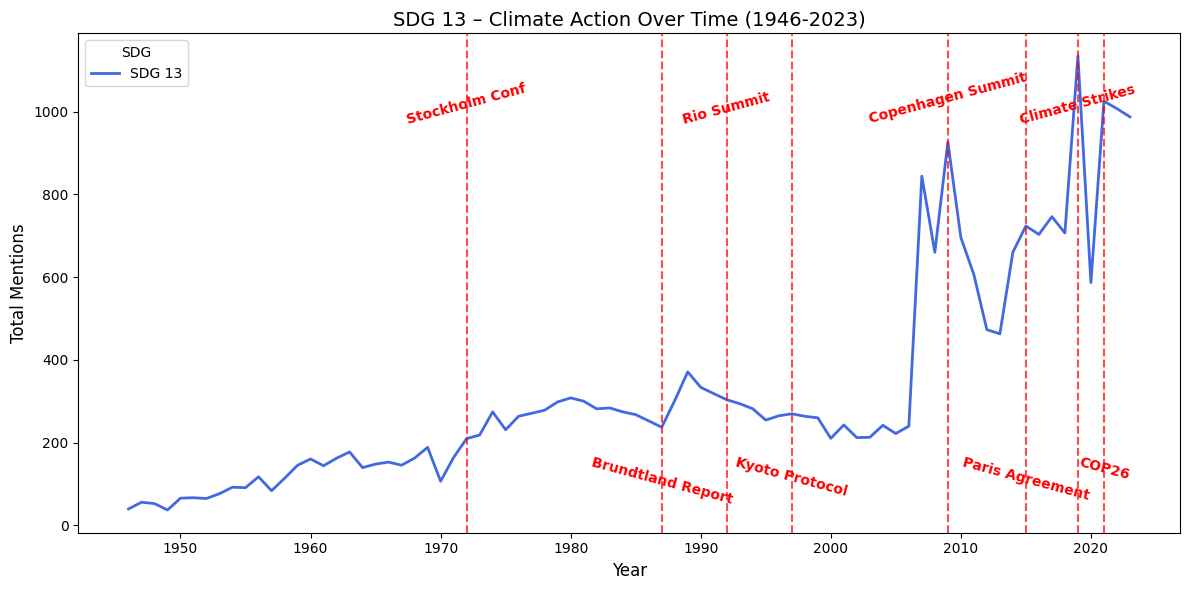

In [39]:
sdg_13_col = "df_sdg13"
sdg_13_by_year = df.groupby("year")[sdg_13_col].sum()

climate_events = {
    1972: ("Stockholm Conf", "top"),
    1987: ("Brundtland Report", "bottom"),
    1992: ("Rio Summit", "top"),
    1997: ("Kyoto Protocol", "bottom"),
    2009: ("Copenhagen Summit", "top"),
    2015: ("Paris Agreement", "bottom"),
    2019: ("Climate Strikes", "top"),
    2021: ("COP26", "bottom")
}

plt.figure(figsize=(12, 6))
plt.plot(sdg_13_by_year.index, sdg_13_by_year, label="SDG 13", color="royalblue", linewidth=2)

for year, (event, position) in climate_events.items():
    plt.axvline(x=year, color="red", linestyle="--", alpha=0.7)
    
    y_position = sdg_13_by_year.max() * (0.85 if position == "top" else 0.15)
    
    plt.text(year, y_position, event, color="red", fontsize=10, rotation=15 if position == "top" else -15, 
             fontweight="bold", ha="center", va="bottom" if position == "top" else "top")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("SDG 13 – Climate Action Over Time (1946-2023)", fontsize=14)
plt.legend(title="SDG", loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

**For 1990 - 2023:**

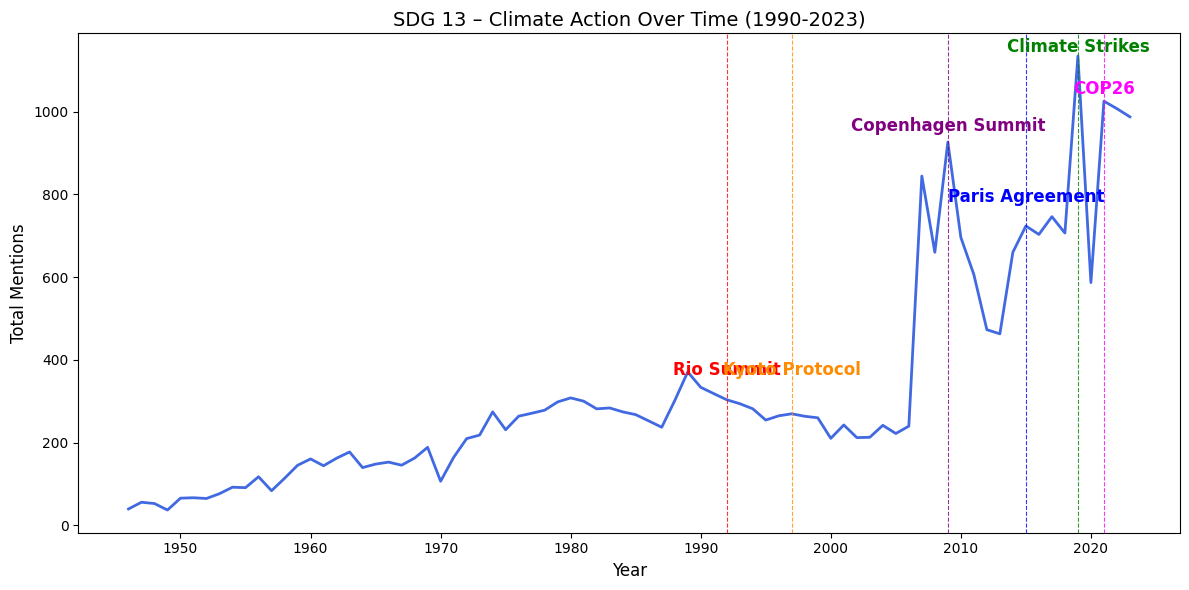

In [40]:
climate_events = {
    1992: ("Rio Summit", "bottom"),
    1997: ("Kyoto Protocol", "bottom"),
    2009: ("Copenhagen Summit", "high-middle"),
    2015: ("Paris Agreement", "low-middle"),
    2019: ("Climate Strikes", "top"),
    2021: ("COP26", "high-middle2")
}

event_colors = {
    "Rio Summit": "red",
    "Kyoto Protocol": "darkorange",
    "Copenhagen Summit": "purple",
    "Paris Agreement": "blue",
    "Climate Strikes": "green",
    "COP26": "magenta"
}

plt.figure(figsize=(12, 6))
plt.plot(sdg_13_by_year.index, sdg_13_by_year, color="royalblue", linewidth=2)

for year, (event, position) in climate_events.items():
    plt.axvline(x=year, color=event_colors[event], linestyle="--", linewidth=0.8, alpha=0.8) 
    
    if position == "top":
        y_position = sdg_13_by_year.max() * 1
        va = "bottom"
    elif position == "high-middle":
        y_position = sdg_13_by_year.max() * 0.85
        va = "center"
    elif position == "high-middle2":
        y_position = sdg_13_by_year.max() * 0.93
        va = "center"
    elif position == "low-middle":
        y_position = sdg_13_by_year.max() * 0.7
        va = "center"
    else:  # "bottom"
        y_position = sdg_13_by_year.max() * 0.35
        va = "top"
    
    plt.text(year, y_position, event, color=event_colors[event], fontsize=12, 
             fontweight="bold", ha="center", va=va)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("SDG 13 – Climate Action Over Time (1990-2023)", fontsize=14)
plt.tight_layout()
plt.show()

#### *SDG 5 (Gender Equality)*

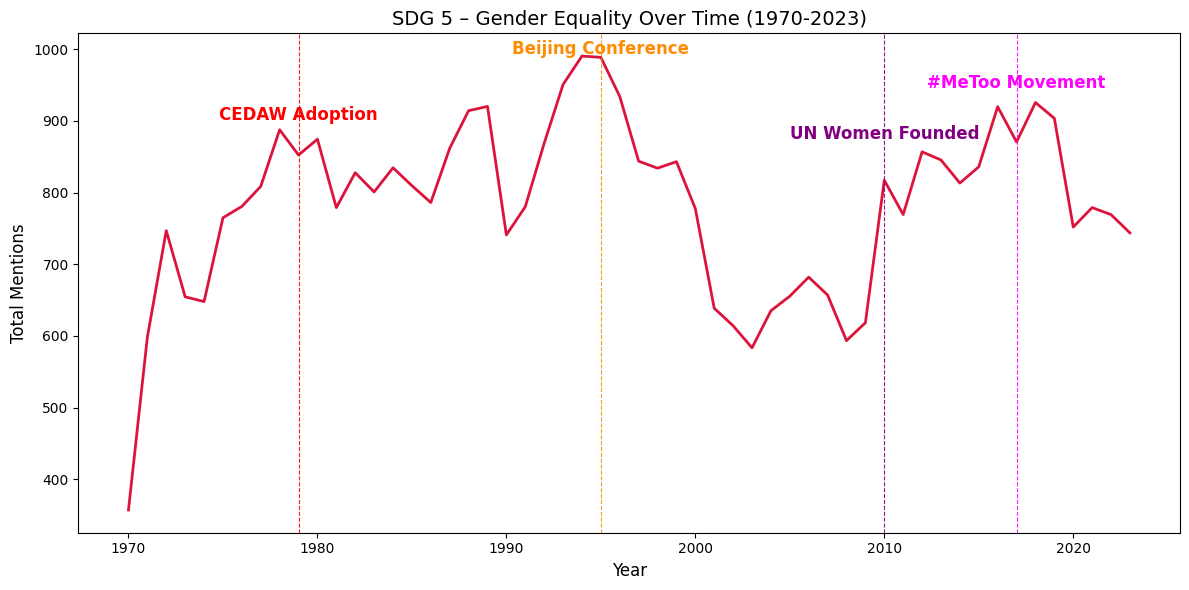

In [41]:
gender_events = {
    1979: ("CEDAW Adoption", "bottom"),
    1995: ("Beijing Conference", "high-middle"),
    2010: ("UN Women Founded", "low-middle"),
    2017: ("#MeToo Movement", "top")
}

event_colors = {
    "CEDAW Adoption": "red",
    "Beijing Conference": "darkorange",
    "UN Women Founded": "purple",
    "#MeToo Movement": "magenta"
}

plt.figure(figsize=(12, 6))

sdg_5_col = "df_sdg05"
sdg_5_by_year = df.groupby("year")[sdg_5_col].sum()
sdg_5_by_year = sdg_5_by_year[sdg_5_by_year.index >= 1970] 

plt.plot(sdg_5_by_year.index, sdg_5_by_year, color="crimson", linewidth=2)

for year, (event, position) in gender_events.items():
    plt.axvline(x=year, color=event_colors[event], linestyle="--", linewidth=0.8, alpha=0.9)  
    
    if position == "top":
        y_position = sdg_5_by_year.max() * 0.95
        va = "bottom"
    elif position == "high-middle":
        y_position = sdg_5_by_year.max() * 1.01
        va = "center"
    elif position == "low-middle":
        y_position = sdg_5_by_year.max() * 0.89
        va = "center"
    else:  # "bottom"
        y_position = sdg_5_by_year.max() * 0.93
        va = "top"
    
    plt.text(year, y_position, event, color=event_colors[event], fontsize=12, 
             fontweight="bold", ha="center", va=va)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("SDG 5 – Gender Equality Over Time (1970-2023)", fontsize=14)
plt.tight_layout()
plt.show()

#### *SDG 3 (Good Health and Well-being)*

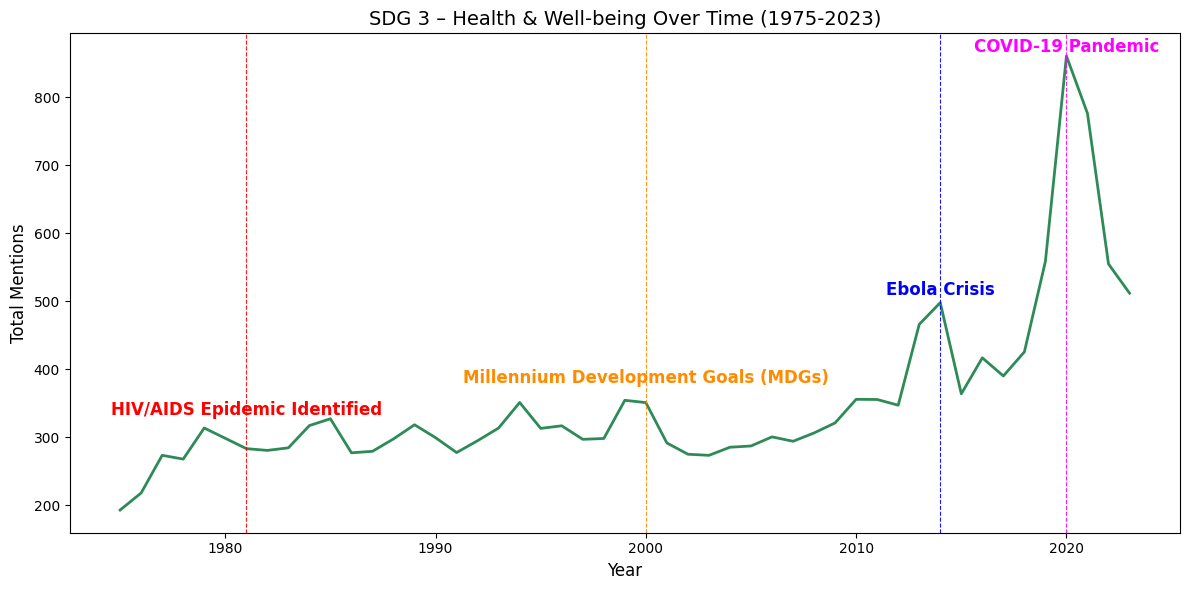

In [42]:
health_events = {
    1981: ("HIV/AIDS Epidemic Identified", "bottom"),
    2000: ("Millennium Development Goals (MDGs)", "high-middle"),
    2014: ("Ebola Crisis", "low-middle"),
    2020: ("COVID-19 Pandemic", "top")
}

event_colors = {
    "HIV/AIDS Epidemic Identified": "red",
    "Millennium Development Goals (MDGs)": "darkorange",
    "SARS Outbreak": "purple",
    "Ebola Crisis": "blue",
    "COVID-19 Pandemic": "magenta"
}

plt.figure(figsize=(12, 6))

sdg_3_col = "df_sdg03"
sdg_3_by_year = df.groupby("year")[sdg_3_col].sum()
sdg_3_by_year = sdg_3_by_year[sdg_3_by_year.index >= 1975]  

plt.plot(sdg_3_by_year.index, sdg_3_by_year, color="seagreen", linewidth=2)

for year, (event, position) in health_events.items():
    plt.axvline(x=year, color=event_colors[event], linestyle="--", linewidth=0.8, alpha=0.9)  
    
    if position == "top":
        y_position = sdg_3_by_year.max() * 1
        va = "bottom"
    elif position == "high-middle":
        y_position = sdg_3_by_year.max() * 0.45
        va = "center"
    elif position == "low-middle":
        y_position = sdg_3_by_year.max() * 0.6
        va = "center"
    else:  # "bottom"
        y_position = sdg_3_by_year.max() * 0.41
        va = "top"
    
    plt.text(year, y_position, event, color=event_colors[event], fontsize=12, 
             fontweight="bold", ha="center", va=va)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("SDG 3 – Health & Well-being Over Time (1975-2023)", fontsize=14)
plt.tight_layout()
plt.show()

#### *SDG 8 (Decent Work and Economic Growth)*

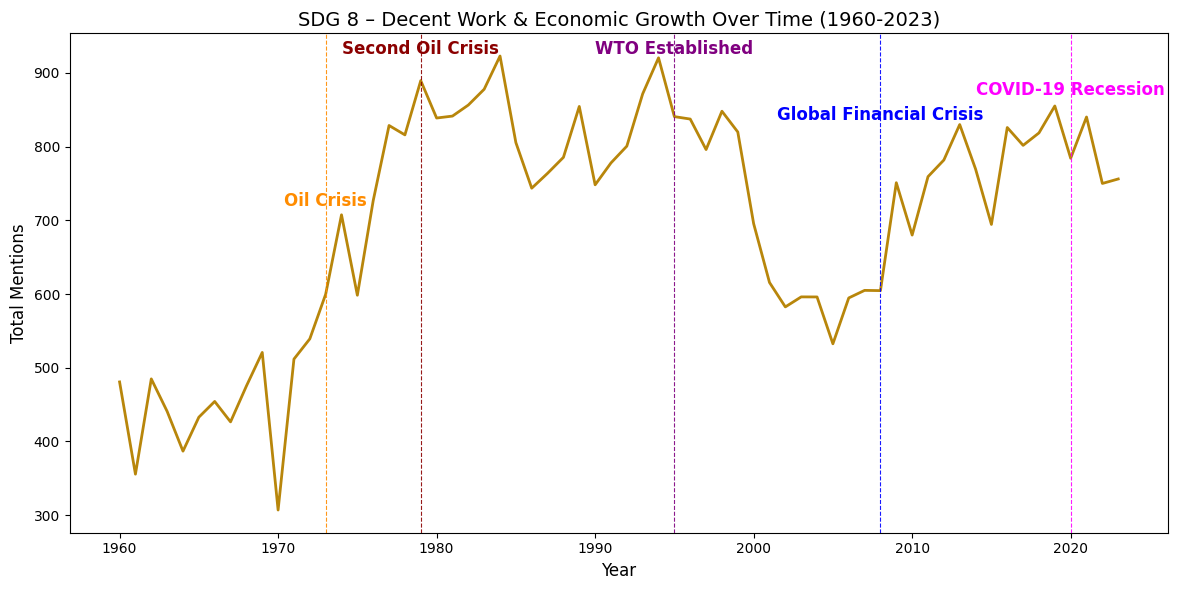

In [43]:
economic_events = {
    1973: ("Oil Crisis", "bottom"),
    1979: ("Second Oil Crisis", "low-middle"),
    1995: ("WTO Established", "low-middle"),
    2008: ("Global Financial Crisis", "top"),
    2020: ("COVID-19 Recession", "high-middle")
}

event_colors = {
    "Second Oil Crisis": "darkred",
    "Oil Crisis": "darkorange",
    "WTO Established": "purple",
    "Global Financial Crisis": "blue",
    "COVID-19 Recession": "magenta"
}

plt.figure(figsize=(12, 6))

sdg_8_col = "df_sdg08"
sdg_8_by_year = df.groupby("year")[sdg_8_col].sum()
sdg_8_by_year = sdg_8_by_year[sdg_8_by_year.index >= 1960] 

plt.plot(sdg_8_by_year.index, sdg_8_by_year, color="darkgoldenrod", linewidth=2)

for year, (event, position) in economic_events.items():
    plt.axvline(x=year, color=event_colors[event], linestyle="--", linewidth=0.8, alpha=0.9)  
    
    if position == "top":
        y_position = sdg_8_by_year.max() * 0.9
        va = "bottom"
    elif position == "high-middle":
        y_position = sdg_8_by_year.max() * 0.95
        va = "center"
    elif position == "low-middle":
        y_position = sdg_8_by_year.max() * 1.01
        va = "center"
    else:  # "bottom"
        y_position = sdg_8_by_year.max() * 0.8
        va = "top"
    
    plt.text(year, y_position, event, color=event_colors[event], fontsize=12, 
             fontweight="bold", ha="center", va=va)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("SDG 8 – Decent Work & Economic Growth Over Time (1960-2023)", fontsize=14)
plt.tight_layout()
plt.show()

### *2) How do international conflicts influence the prominence of SDG 16-related topics in UN General Assembly speeches, and how do countries directly involved in these conflicts adjust their discourse compared to others?*

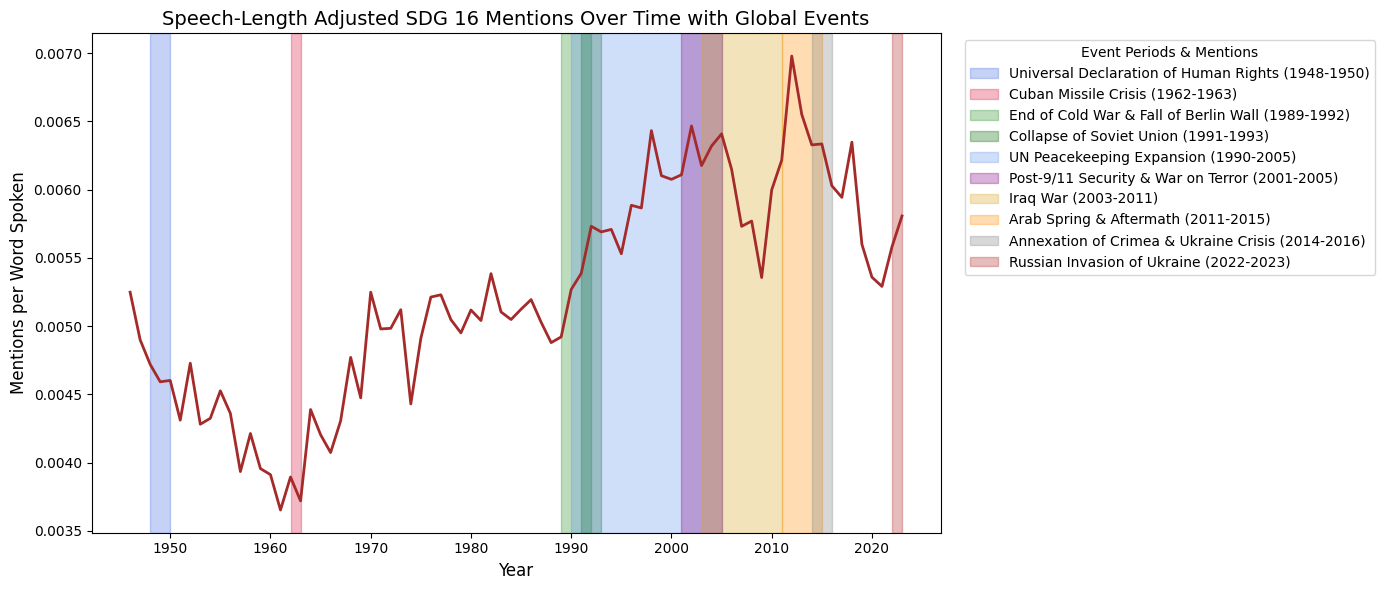

In [44]:
sdg16_by_year = df.groupby("year")["df_sdg16"].sum()

words_per_year = df.groupby("year")["processed_text"].apply(lambda x: x.str.split().str.len().sum())

adjusted_sdg16_by_year = sdg16_by_year / words_per_year

global_event_periods = {
    (1948, 1950): "Universal Declaration of Human Rights",
    (1962, 1963): "Cuban Missile Crisis",
    (1989, 1992): "End of Cold War & Fall of Berlin Wall",
    (1991, 1993): "Collapse of Soviet Union",
    (1990, 2005): "UN Peacekeeping Expansion",
    (2001, 2005): "Post-9/11 Security & War on Terror",
    (2003, 2011): "Iraq War",
    (2011, 2015): "Arab Spring & Aftermath",
    (2014, 2016): "Annexation of Crimea & Ukraine Crisis",
    (2022, 2023): "Russian Invasion of Ukraine"
}

event_colors = {
    "Universal Declaration of Human Rights": "royalblue",
    "Cuban Missile Crisis": "crimson",
    "End of Cold War & Fall of Berlin Wall": "forestgreen",
    "Collapse of Soviet Union": "darkgreen",
    "UN Peacekeeping Expansion": "cornflowerblue",
    "Post-9/11 Security & War on Terror": "purple",
    "Iraq War": "goldenrod",
    "Arab Spring & Aftermath": "darkorange",
    "Annexation of Crimea & Ukraine Crisis": "gray",
    "Russian Invasion of Ukraine": "firebrick"
}

plt.figure(figsize=(14, 6))
plt.plot(adjusted_sdg16_by_year.index, adjusted_sdg16_by_year, color="brown", linewidth=2, label="Mentions Adjusted for Speech Length")

for (start, end), event in global_event_periods.items():
    plt.axvspan(start, end, color=event_colors[event], alpha=0.3, label=event if start == end else None)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Mentions per Word Spoken", fontsize=12)
plt.title("Speech-Length Adjusted SDG 16 Mentions Over Time with Global Events", fontsize=14)

handles = [plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.3) for color in event_colors.values()]
labels = [f"{event} ({start}-{end})" for (start, end), event in global_event_periods.items()]
plt.legend(handles, labels, title="Event Periods & Mentions", loc="upper left", fontsize=10, bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

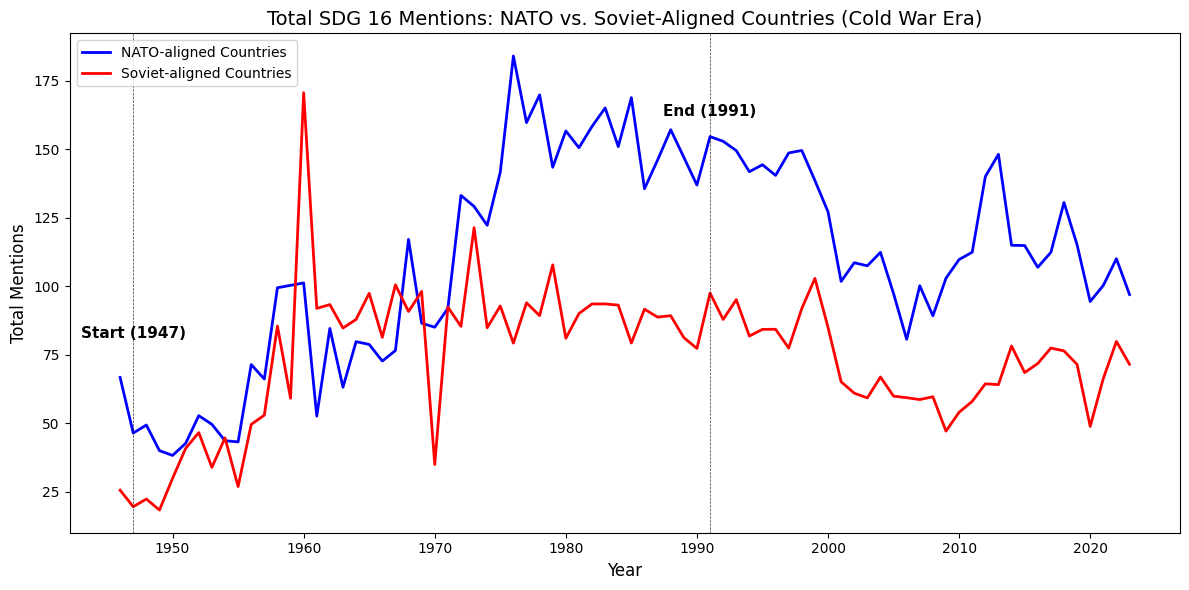

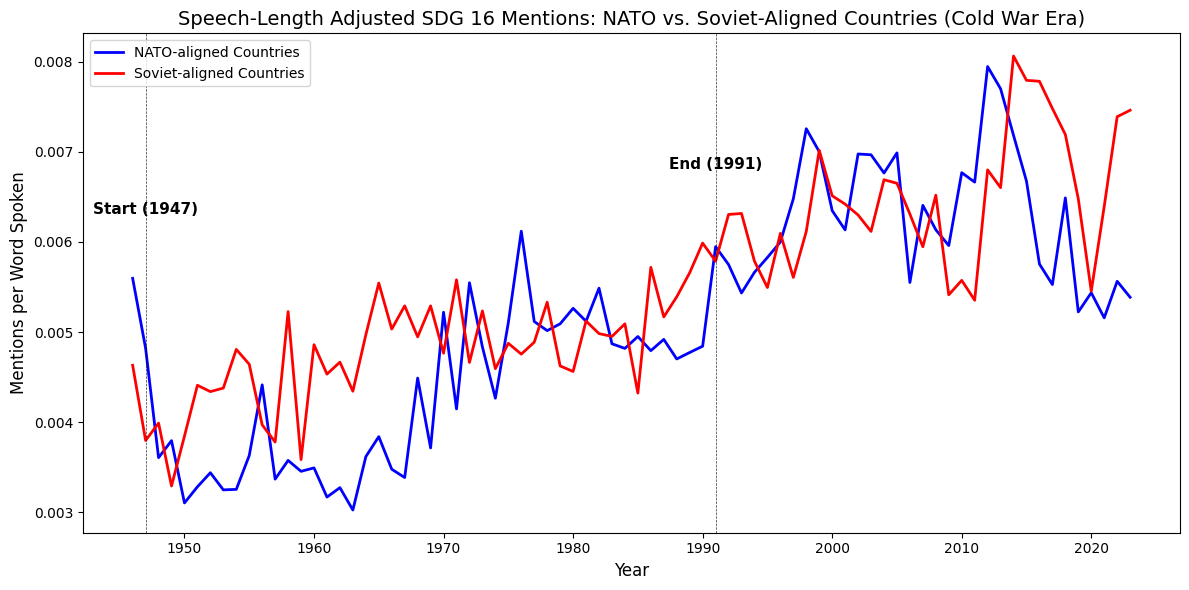

In [45]:
nato_aligned = [
    "USA", "CAN", "GBR", "FRA", "DEU", "ITA", "NLD", "BEL", "DNK", "NOR",
    "GRC", "TUR", "PRT", "ESP", "LUX", "ISL"
]

soviet_aligned = [
    "USSR", "POL", "HUN", "CZE", "BGR", "ROU", "YUG", "ALB", "GDR", "CUB",
    "VNM", "CHN", "PRK"
]

# Aggregate total SDG 16 mentions per year for each group
nato_sdg16_by_year = df[df["ccodealp"].isin(nato_aligned)].groupby("year")["df_sdg16"].sum()
soviet_sdg16_by_year = df[df["ccodealp"].isin(soviet_aligned)].groupby("year")["df_sdg16"].sum()

# Aggregate total words spoken per year for normalization
nato_words_by_year = df[df["ccodealp"].isin(nato_aligned)].groupby("year")["processed_text"].apply(lambda x: x.str.split().str.len().sum())
soviet_words_by_year = df[df["ccodealp"].isin(soviet_aligned)].groupby("year")["processed_text"].apply(lambda x: x.str.split().str.len().sum())

# Speech-length adjusted mentions (mentions per word spoken)
adjusted_nato_sdg16_by_year = nato_sdg16_by_year / nato_words_by_year
adjusted_soviet_sdg16_by_year = soviet_sdg16_by_year / soviet_words_by_year

cold_war_events = {
    1947: ("Start (1947)", "top"),
    1991: ("End (1991)", "bottom")
}

# Total Mentions (Unadjusted)
plt.figure(figsize=(12, 6))
plt.plot(nato_sdg16_by_year.index, nato_sdg16_by_year, color="blue", linewidth=2, label="NATO-aligned Countries")
plt.plot(soviet_sdg16_by_year.index, soviet_sdg16_by_year, color="red", linewidth=2, label="Soviet-aligned Countries")

for year, (event, position) in cold_war_events.items():
    plt.axvline(x=year, color="black", linestyle="--", linewidth=0.5, alpha=0.8)

    if position == "top":
        y_position = nato_sdg16_by_year.max() * 0.45
    else:  
        y_position = soviet_sdg16_by_year.max() * 0.96

    plt.text(year, y_position, event, color="black", fontsize=11, fontweight="bold", ha="center", va="center")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Mentions", fontsize=12)
plt.title("Total SDG 16 Mentions: NATO vs. Soviet-Aligned Countries (Cold War Era)", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


# Speech-Length Adjusted Mentions
plt.figure(figsize=(12, 6))
plt.plot(adjusted_nato_sdg16_by_year.index, adjusted_nato_sdg16_by_year, color="blue", linewidth=2, label="NATO-aligned Countries")
plt.plot(adjusted_soviet_sdg16_by_year.index, adjusted_soviet_sdg16_by_year, color="red", linewidth=2, label="Soviet-aligned Countries")

for year, (event, position) in cold_war_events.items():
    plt.axvline(x=year, color="black", linestyle="--", linewidth=0.5, alpha=0.8)
    
    if position == "top":
        y_position = adjusted_nato_sdg16_by_year.max() * 0.8
    else: 
        y_position = adjusted_soviet_sdg16_by_year.max() * 0.85

    plt.text(year, y_position, event, color="black", fontsize=11, fontweight="bold", ha="center", va="center")

plt.xlabel("Year", fontsize=12)
plt.ylabel("Mentions per Word Spoken", fontsize=12)
plt.title("Speech-Length Adjusted SDG 16 Mentions: NATO vs. Soviet-Aligned Countries (Cold War Era)", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()